# Analysis of customer churn in a chain of fitness centers

<a id="num1"></a>
## Introduction

**Task** - Analyze and prepare an action plan for customer retention.

**Necessary:**

1. Cg-forecast the probability of churn (at next month's level) for each customer;

2. To form typical portraits of clients: to identify several most prominent groups and characterize their main properties;

3. Analyze the main attributes that most strongly influence churn;

4. Formulate the main conclusions and develop recommendations to improve the quality of work with clients.

# Table of Contents 

* [1. Data import](#num1)
* [2. Exploratory Data Analysis (EDA)](#num2)
    * [2.1. Comparison of mean values in two groups](#num21)
    * [2.2. Graphs comparing the distribution of traits in two groups](#num22)
    * [2.3. Correlation matrix](#num23)
* [3. Building a model for predicting customer churn](#num3)
    * [3.1. Model Training: Logistic Regression](#num31)
    * [3.2. Model Training: Random Forest](#num32)
    * [3.3. Comparing the quality of trained model predictions](#num33)
* [4. Customer Clustering](#num4)
    * [4.1. Data standardization and dendrogram construction](#num41)
    * [4.2. Training the clustering model based on the K-Means algorithm](#num42)
* [5. General conclusions and basic recommendations](#num5)

<a id="num1"></a>
# 1. Data Ipmort

In [39]:
# Import standard libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math as mth
from scipy import stats as st
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

# Seaborn settings.
sns.set()

# Import sklearn classes.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

In [40]:
# Read the data file.
data = pd.read_csv('gym_churn.csv', sep=',')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [42]:
data.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Conclusion:**

Our data contains 4 thousand records and 14 variables. All variables have no missing or null values, which indicates good data quality. All variables are cast to the appropriate data types: int64 and float64, which greatly simplifies the analysis of this data.

Note that all quantitative attributes such as contract period, age, amount of additional costs, lifetime and average visit frequency are presented in numeric format, which allows us to use a wide range of statistical methods to explore these data.

It is also important to note that the churn column is presented in binary format (0 or 1), which is ideal for binary classification tasks. So, in summary, the data are well structured and ready for further analysis.

<a id="num2"></a>
# 2. Exploratory Data Analysis (EDA)

In [43]:
# Examine averages and standard deviations.
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


**Conclusion:**

1. Almost equal numbers of men and women visit the fitness center, as the mean value of gender is 0.51.

2. The majority of clients (85%) live or work in the area of the fitness center.

3. Almost half of the clients (49%) are employees of the club's partner companies.

4. 31% of clients signed up for the first time as part of the "Bring a Friend" promotion.

5. 90% of clients have a contact phone number provided.

6. The average age of clients is 29 years old.

7. The average duration of a subscription is 5 months.

8. 41% of clients attended group exercise classes.

9. The average frequency of visits per week for the entire time since the start of the subscription and the last month is 1.88 and 1.77 respectively.

10. The average amount of additional revenue from other fitness center services is $146.94.

11. The churn rate for the current month is 27%.


In [44]:
print('Number of missing values:', data.isnull().sum().sum())   # number of missing values
print('Number of complete duplicates:', data.duplicated().sum())     # number of complete duplicates
print('Percentage of duplicates:', '{:.1%}'.format((data.duplicated().sum() / len(data)))) # percentage of duplicates

Number of missing values: 0
Number of complete duplicates: 0
Percentage of duplicates: 0.0%


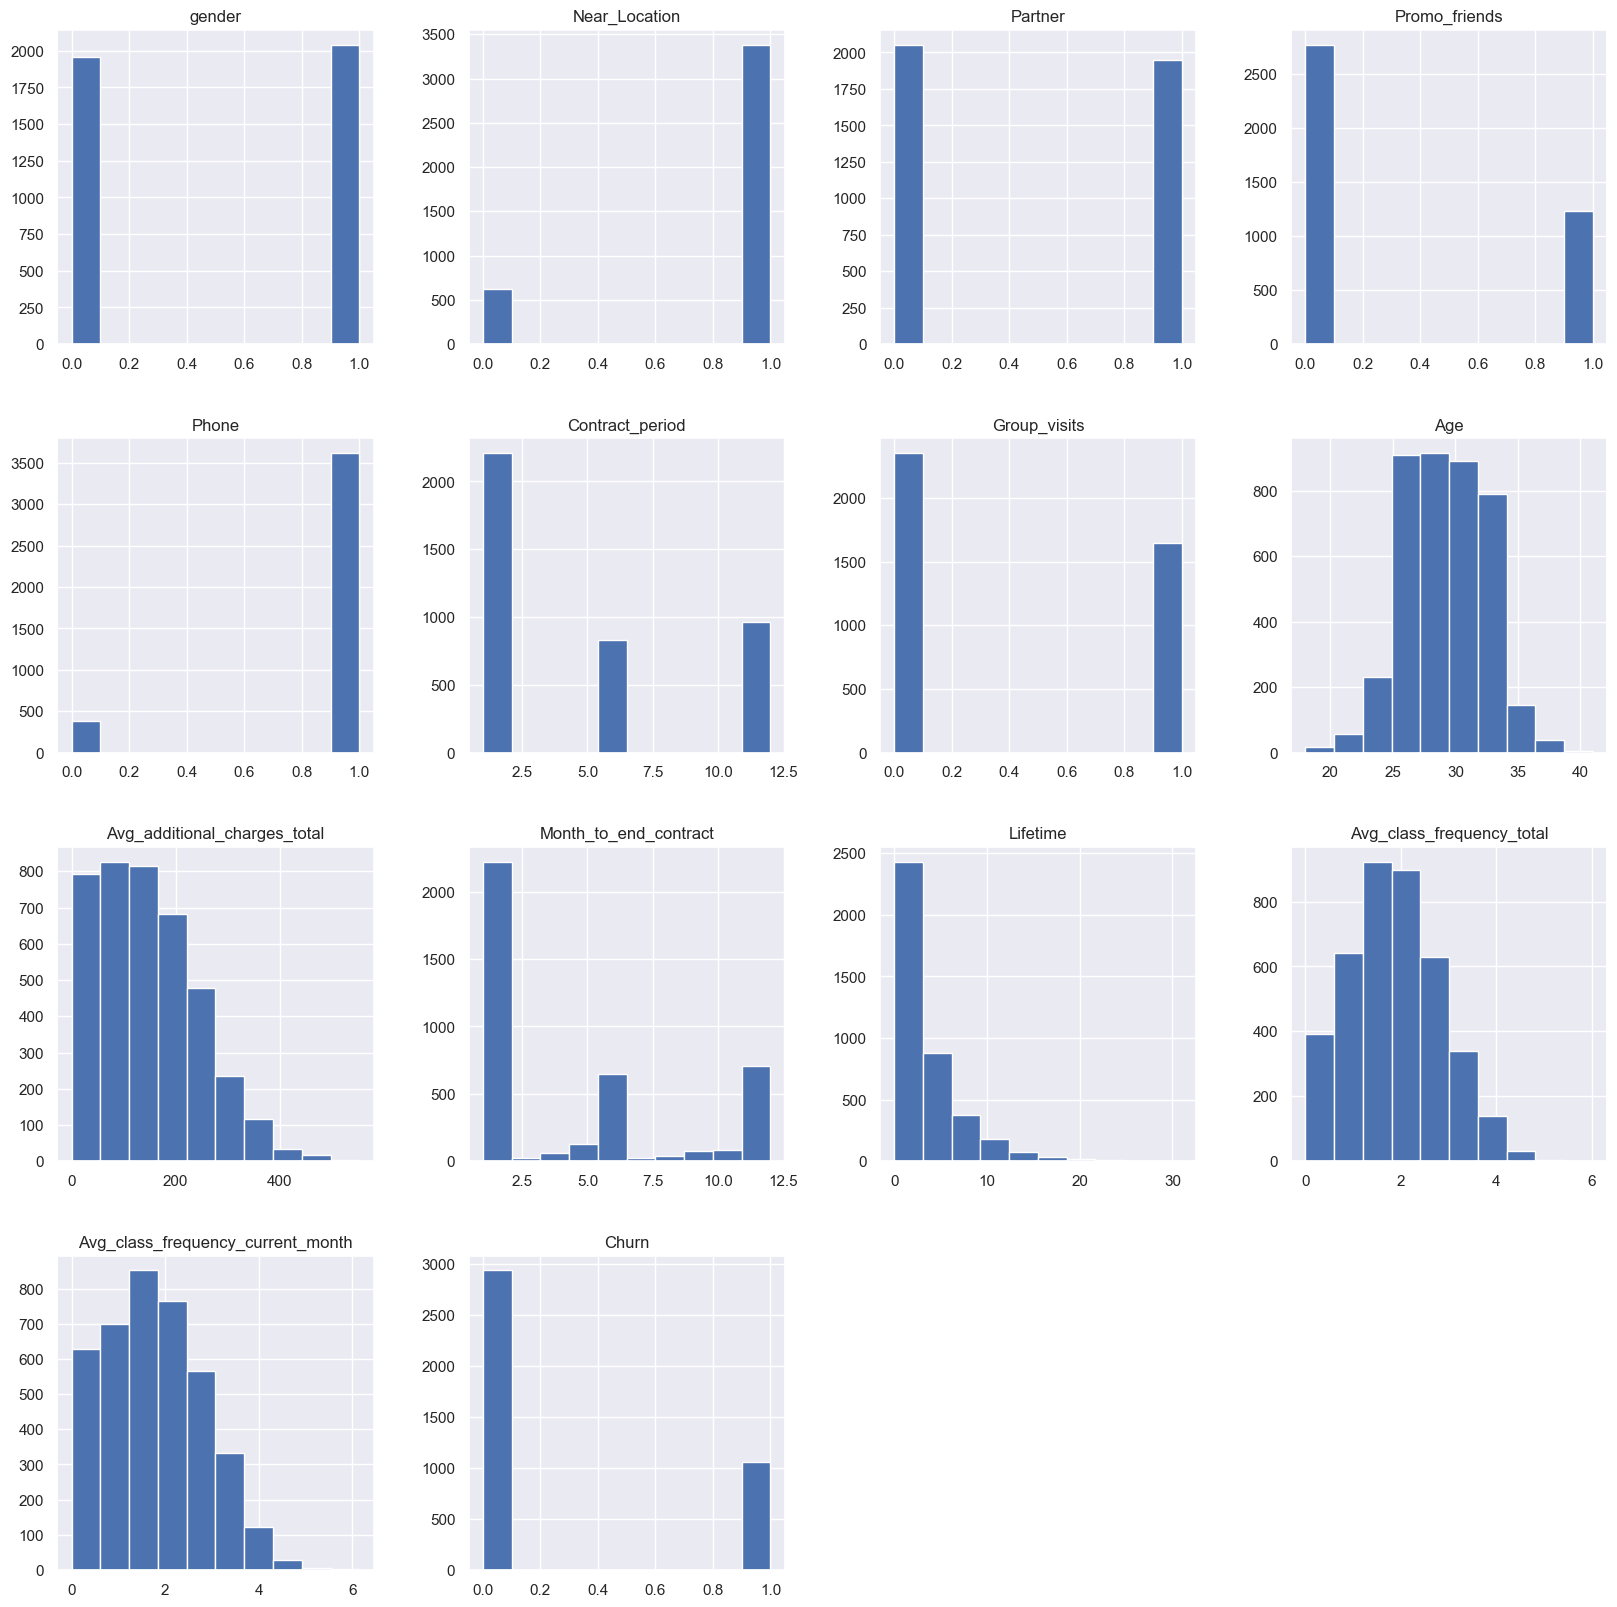

In [45]:
# Build histograms for the entire dataset.
data.hist(figsize = (20,20)) 
plt.show()

In [46]:
# Let's calculate the churn rate.
churn_rate = data['Churn'][data['Churn'] == 1].count()/ len(data) * 100
churn_rate = churn_rate.round(2)
print('Customer churn rate:', churn_rate,'%')

Customer churn rate: 26.52 %


**Conclusion:**

* __No__ missing values.
* __No__ complete duplicates.
* All columns have __correct__ data type.
* __No anomalous values__ are observed.
* The distribution of values in the sample is __normal__.
* Customer churn rate: __26.52%__

<a id="num21"></a>
### 2.1 Comparison of mean values in two groups

In [47]:
# Average values of features in two groups.
data.groupby('Churn').mean().reset_index().round(3).T

,0,1
Churn,0.000,1.000
gender,0.510,0.511
Near_Location,0.873,0.768
Partner,0.534,0.355
Promo_friends,0.354,0.184
Phone,0.904,0.903
Contract_period,5.747,1.729
Group_visits,0.464,0.269
Age,29.977,26.990
Avg_additional_charges_total,158.446,115.083


The following conclusions can be drawn from the data above:

* Churn and non-churn customers have almost the same gender split.
* Clients who live or work near the fitness center are less likely to churn.
* Clients who are employees of the club's partner companies or who came under the "Bring a Friend" program are less likely to leave.
* The length of a current membership is significantly shorter on average for churners than for those who stay (1.7 months vs. 5.7 months).
* Churned customers are less likely to attend group exercise classes.
* The average age of churn clients is lower than those who stay (27 years old vs. 30 years old).
* Weaning clients have significantly lower amounts of additional spending than those who stay.
* The time to the end of the current active subscription is shorter for those who leave.
* The time since the first contact to the fitness center (Lifetime) for the churned customers is on average less than 1 month, while for the remaining customers this value is more than 4.5 months.
* The average frequency of visits per week is lower among the weaning clients, both for all time and for the last month.

Overall, the primary data indicate that clients with longer subscriptions, higher frequency of visits and more additional spending are less likely to churn.

<a id="num22"></a>
### 2.2 Plots comparing the distribution of traits in two groups

In [48]:
# Create two separate dataframes separated by the 'Churn' keyword.
gym_churn_0 = data.query('Churn == 0').reset_index(drop=True).drop(['Churn', 'Phone', 'gender', 'Near_Location'], axis = 1)
gym_churn_1 = data.query('Churn == 1').reset_index(drop=True)

In [49]:
#List of plot titles.
title_list = ['Share of customers who are employees of partner companies',
'Share of customers participating in the "bring a friend" program',
'Duration of current active subscription',
'Share of customers attending group classes',
'Customer age',
'Total revenue from other fitness center services',
'Term to the end of the current active subscription (in months)',
'Time since first visit to fitness center (in months)',
'Average frequency of visits per week since the start of the subscription',
'Average frequency of visits per week for the previous month']

#List of X-axis labels.
xlabel_list = ['Employees of partner companies',
'Participants in the "bring a friend" program',
'Current active subscription duration (month)',
'Group visits', 'Customer age',
'Average revenue from other services',
'Months to end of current subscription',
'Months since first visit',
'Average number of visits per week',
'Average number of visits per week last month']

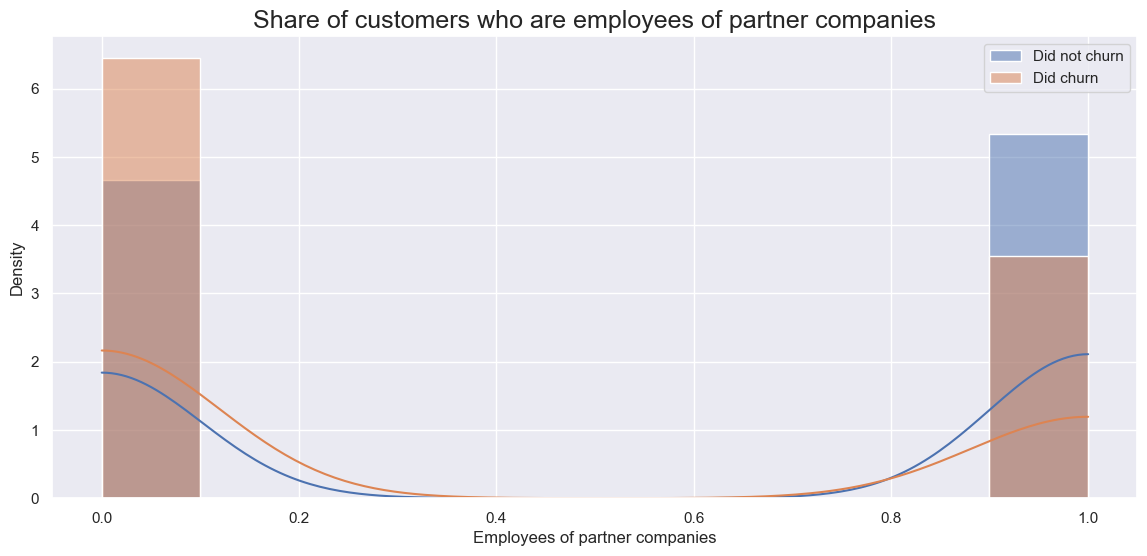

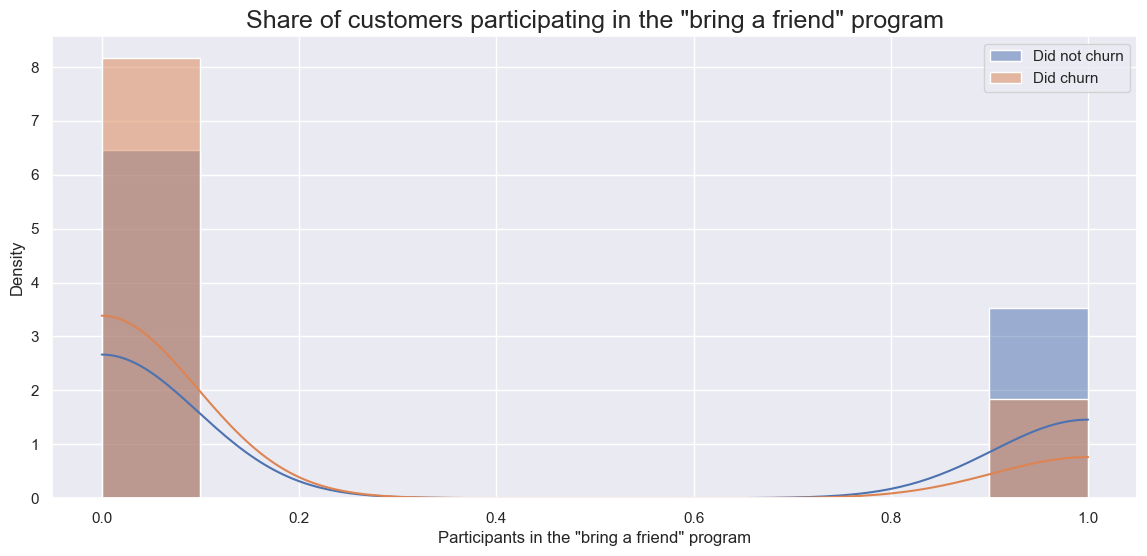

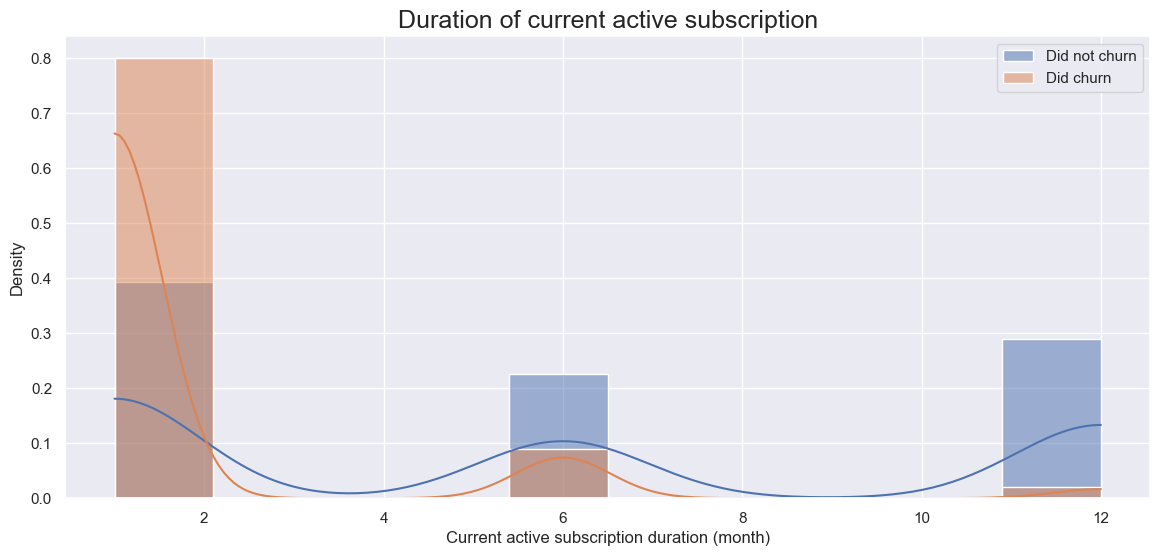

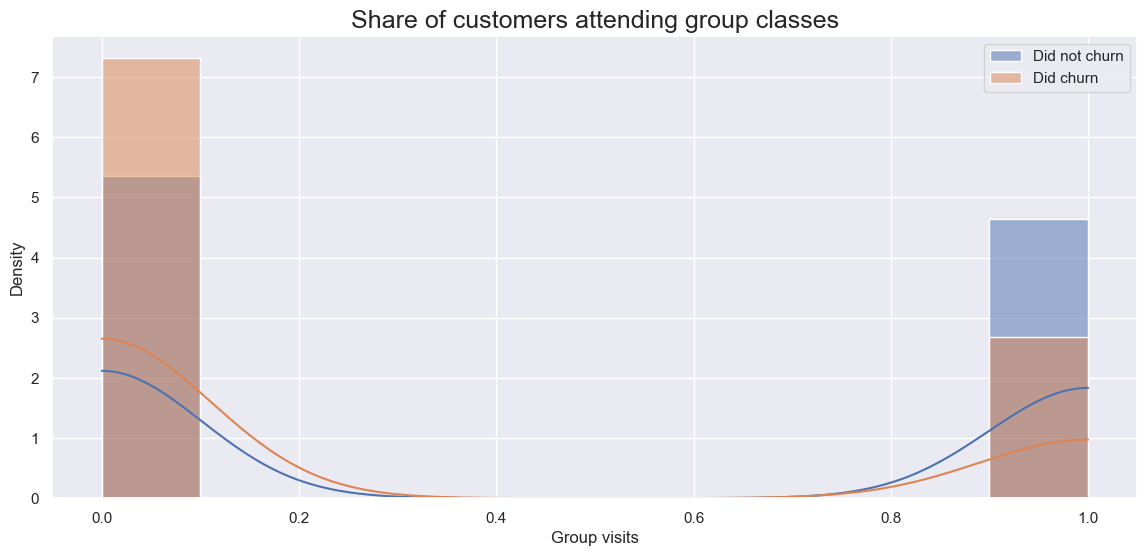

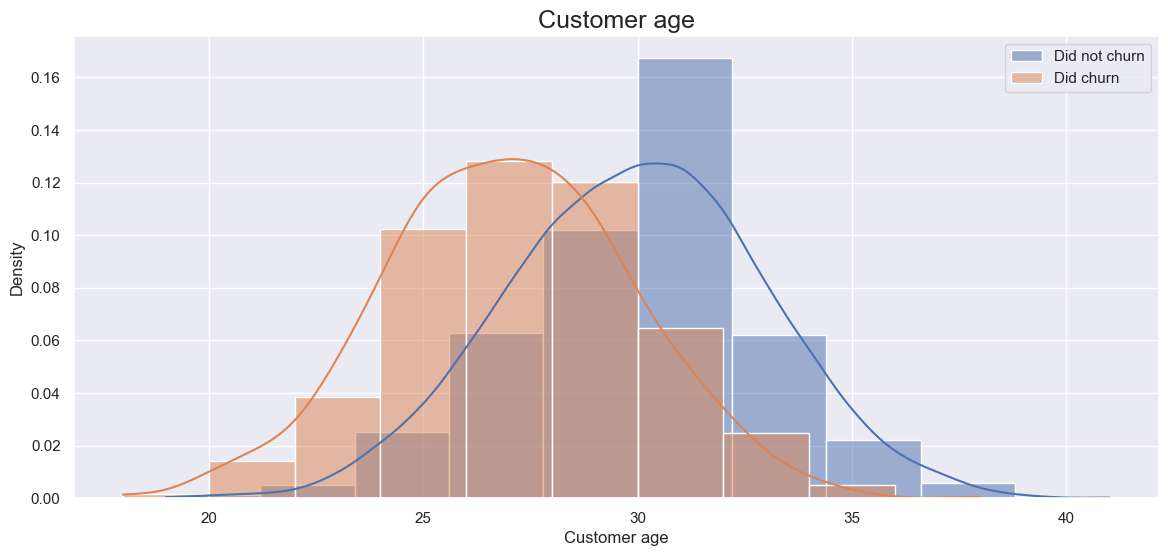

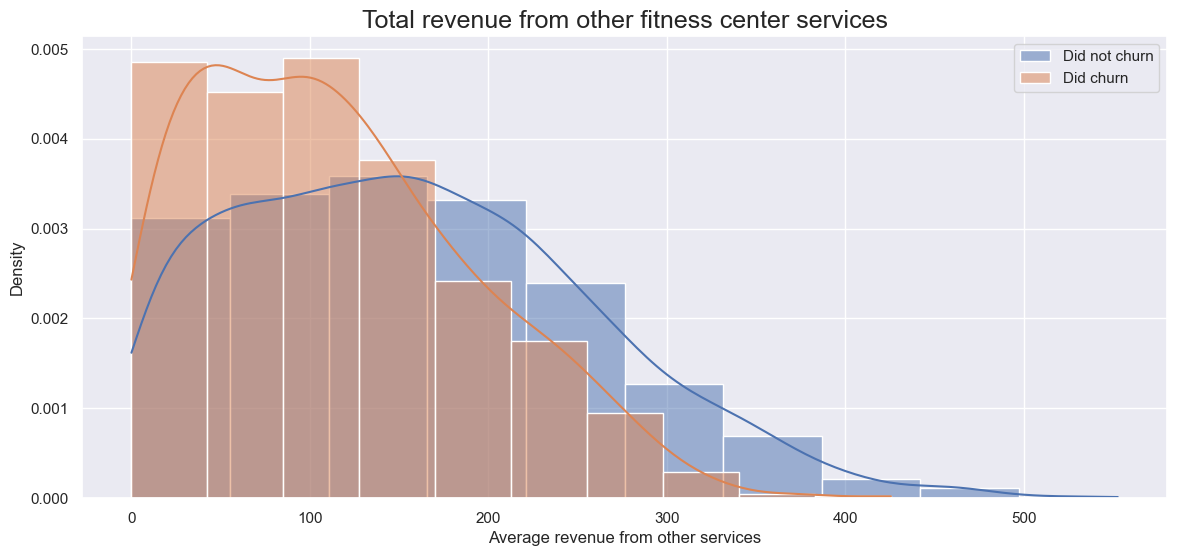

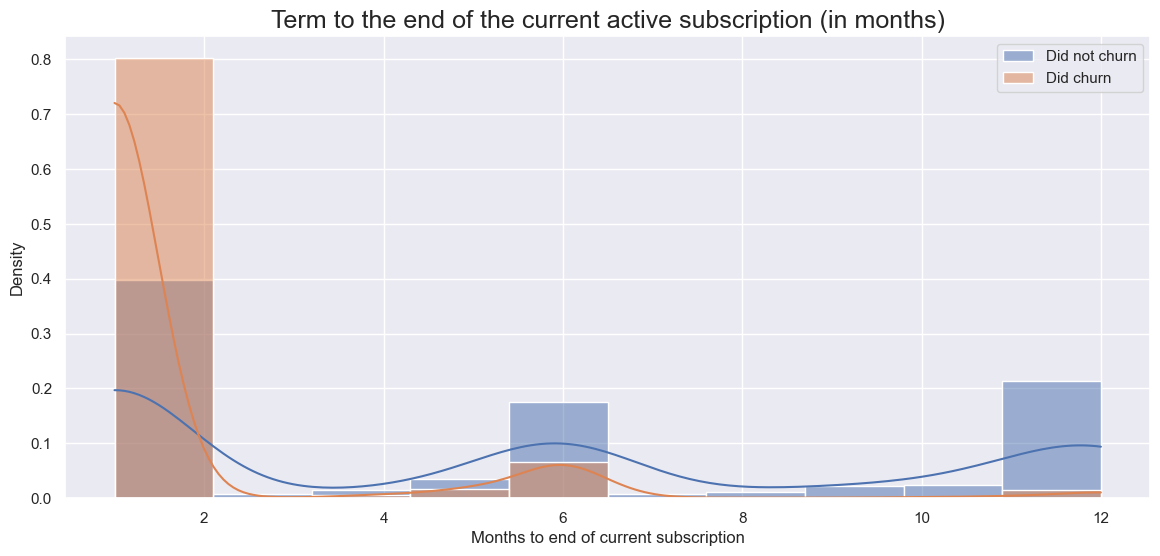

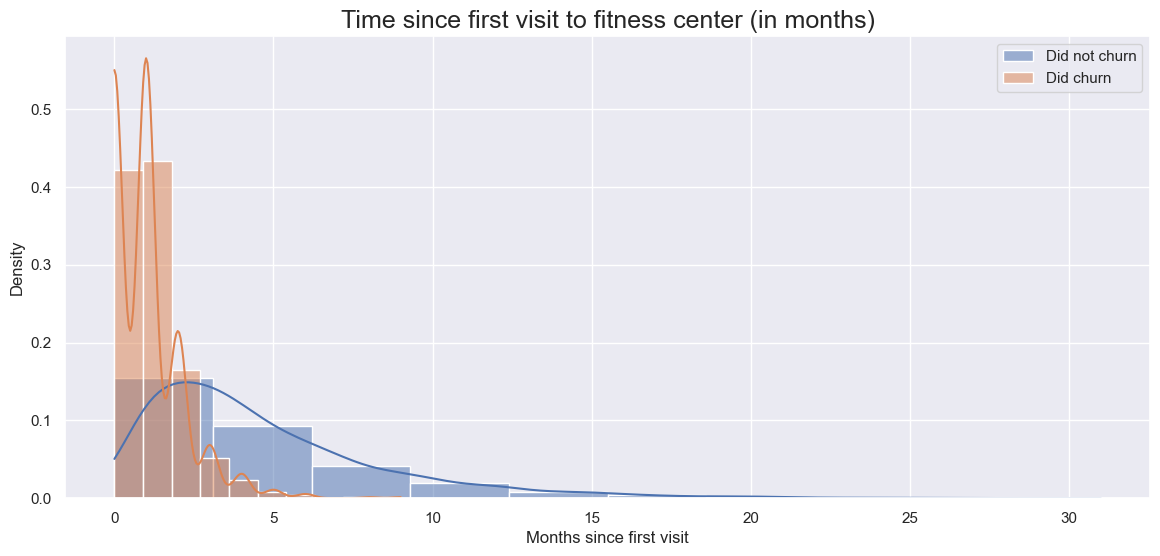

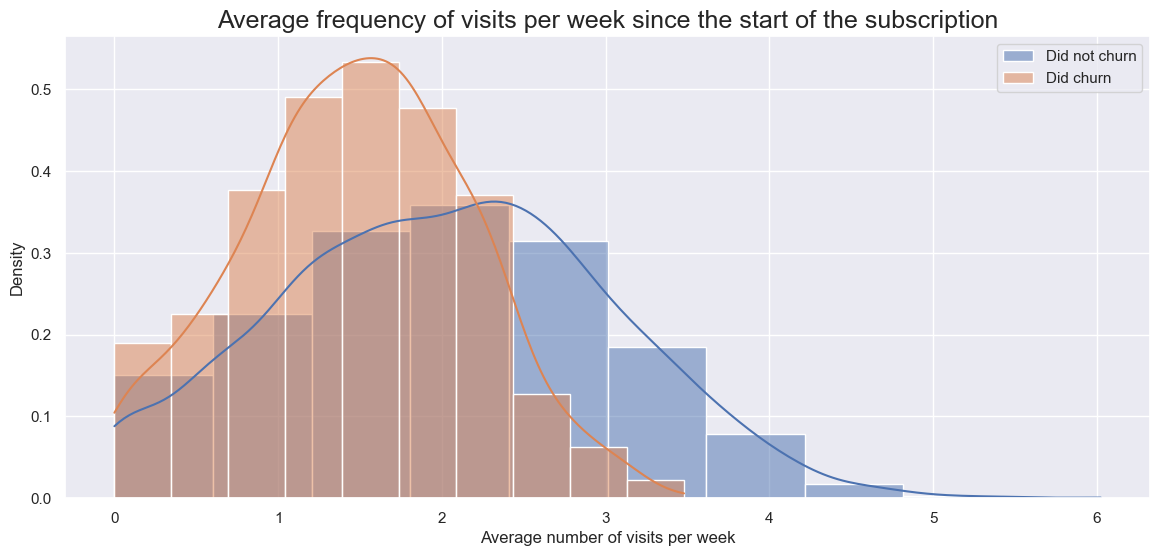

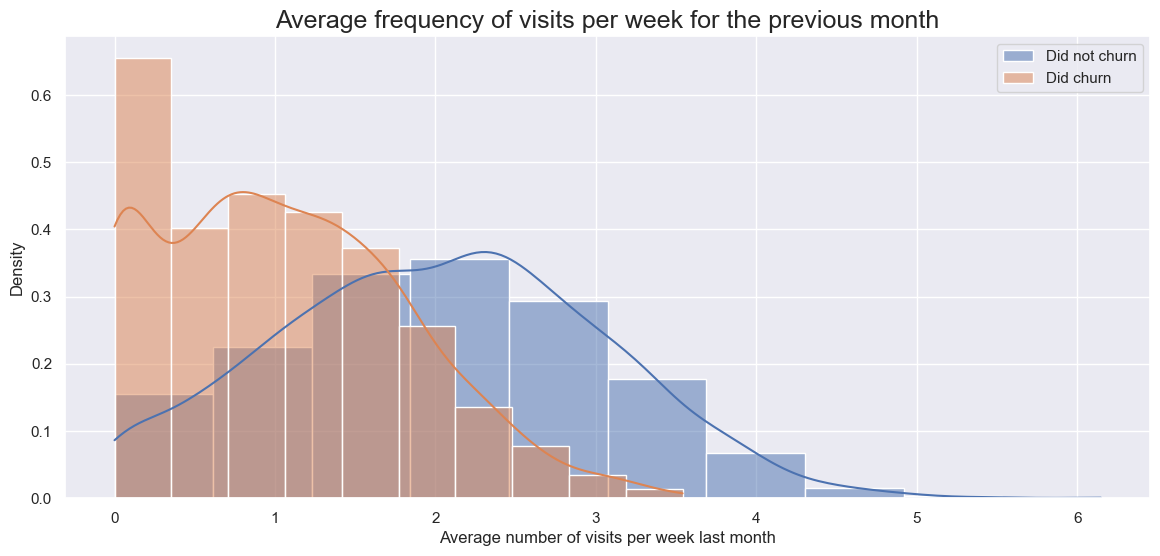

In [50]:
# Loop to create histograms.
count = 0 

for feature in gym_churn_0.columns:
    fig = plt.gcf()
    plt.title(title_list[count], fontsize=18) 
    fig.set_size_inches(14, 6)
    
    sns.histplot(gym_churn_0[feature], bins = 10, 
                 label='Did not churn', stat="density", kde=True).set(xlabel=xlabel_list[count])
    
    sns.histplot(gym_churn_1[feature], bins = 10, 
                 label='Did churn', stat="density", kde=True).set(xlabel=xlabel_list[count])
    
    plt.legend()
    plt.show()
    count = count + 1

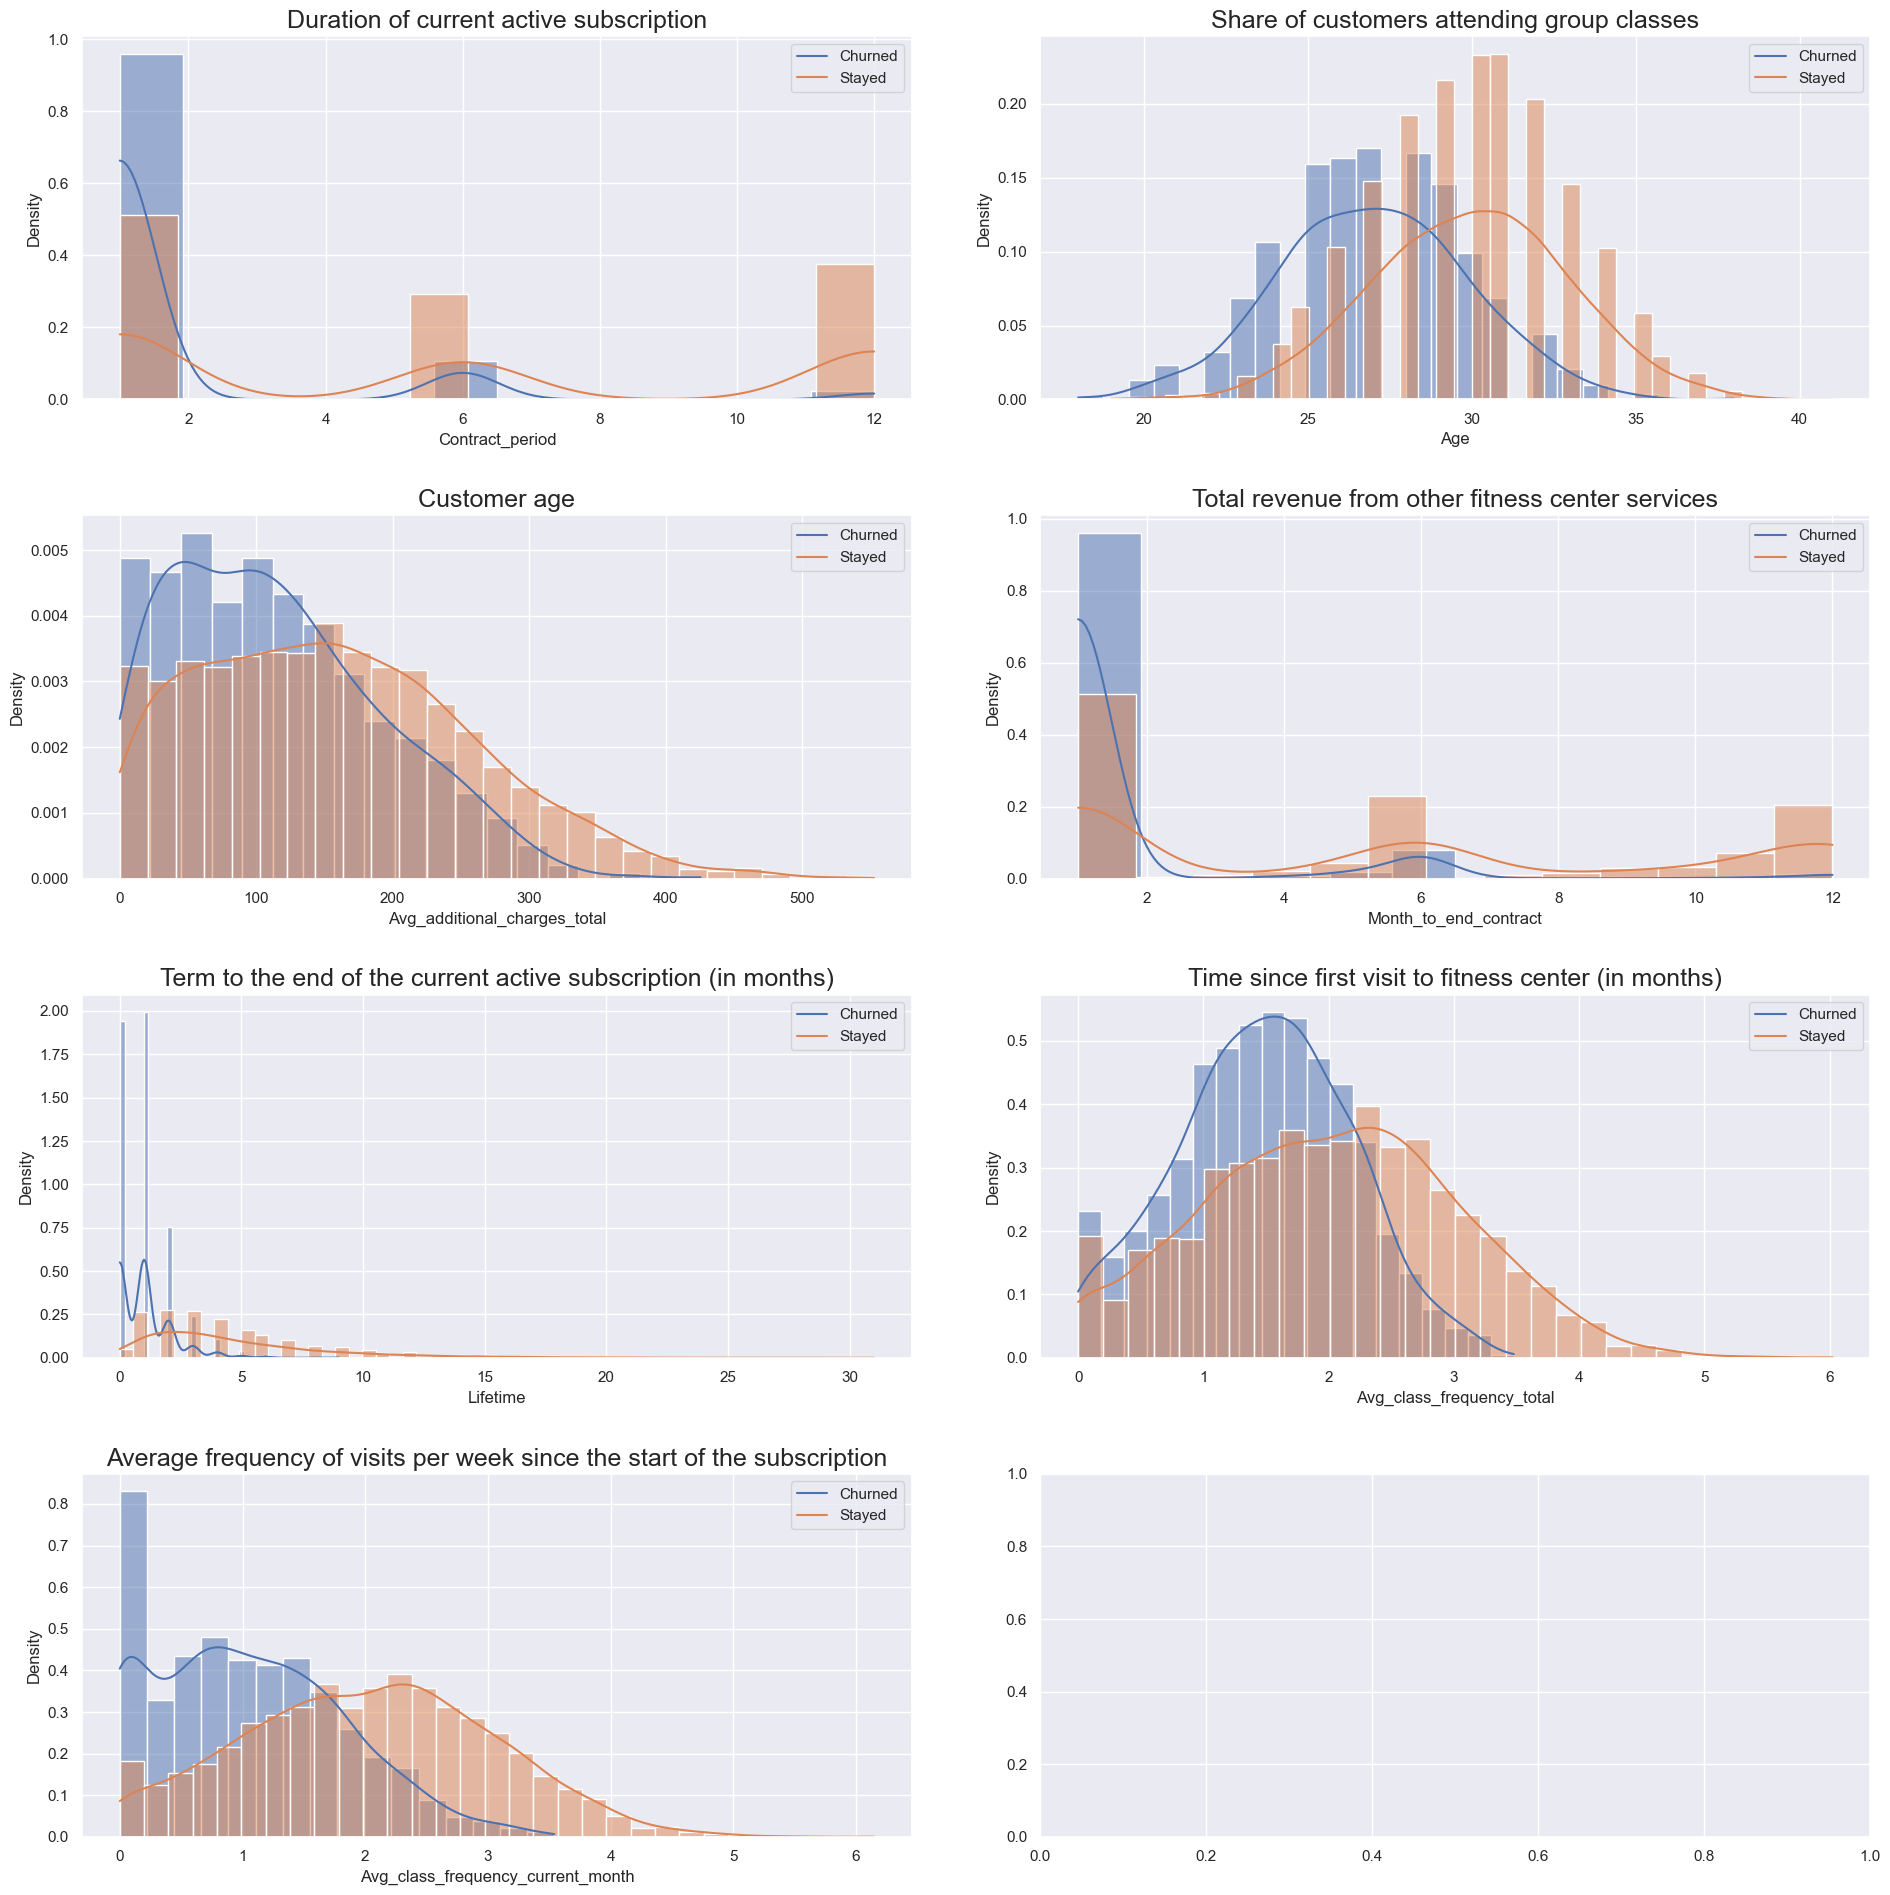

In [51]:
# Select the columns for the distribution plot.
distplot_columns = [
    'Contract_period', 'Age', 'Avg_additional_charges_total',
    'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 
    'Avg_class_frequency_current_month'
]

# Define the figure size and layout.
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
fig.tight_layout(pad=5.0)

# Create the histplot for each column in the subplot.
for i, ax in enumerate(axs.flat[:len(distplot_columns)]):
    ax.set_title(title_list[i+2], fontsize=18) 
    
    # Plot distribution of customers who churned.
    sns.histplot(data[data['Churn']==1][distplot_columns[i]], ax=ax, stat="density", kde=True)
    
    # Plot distribution of customers who stayed.
    sns.histplot(data[data['Churn']==0][distplot_columns[i]], ax=ax, stat="density", kde=True)
    
    ax.legend(['Churned', 'Stayed'])

plt.show()

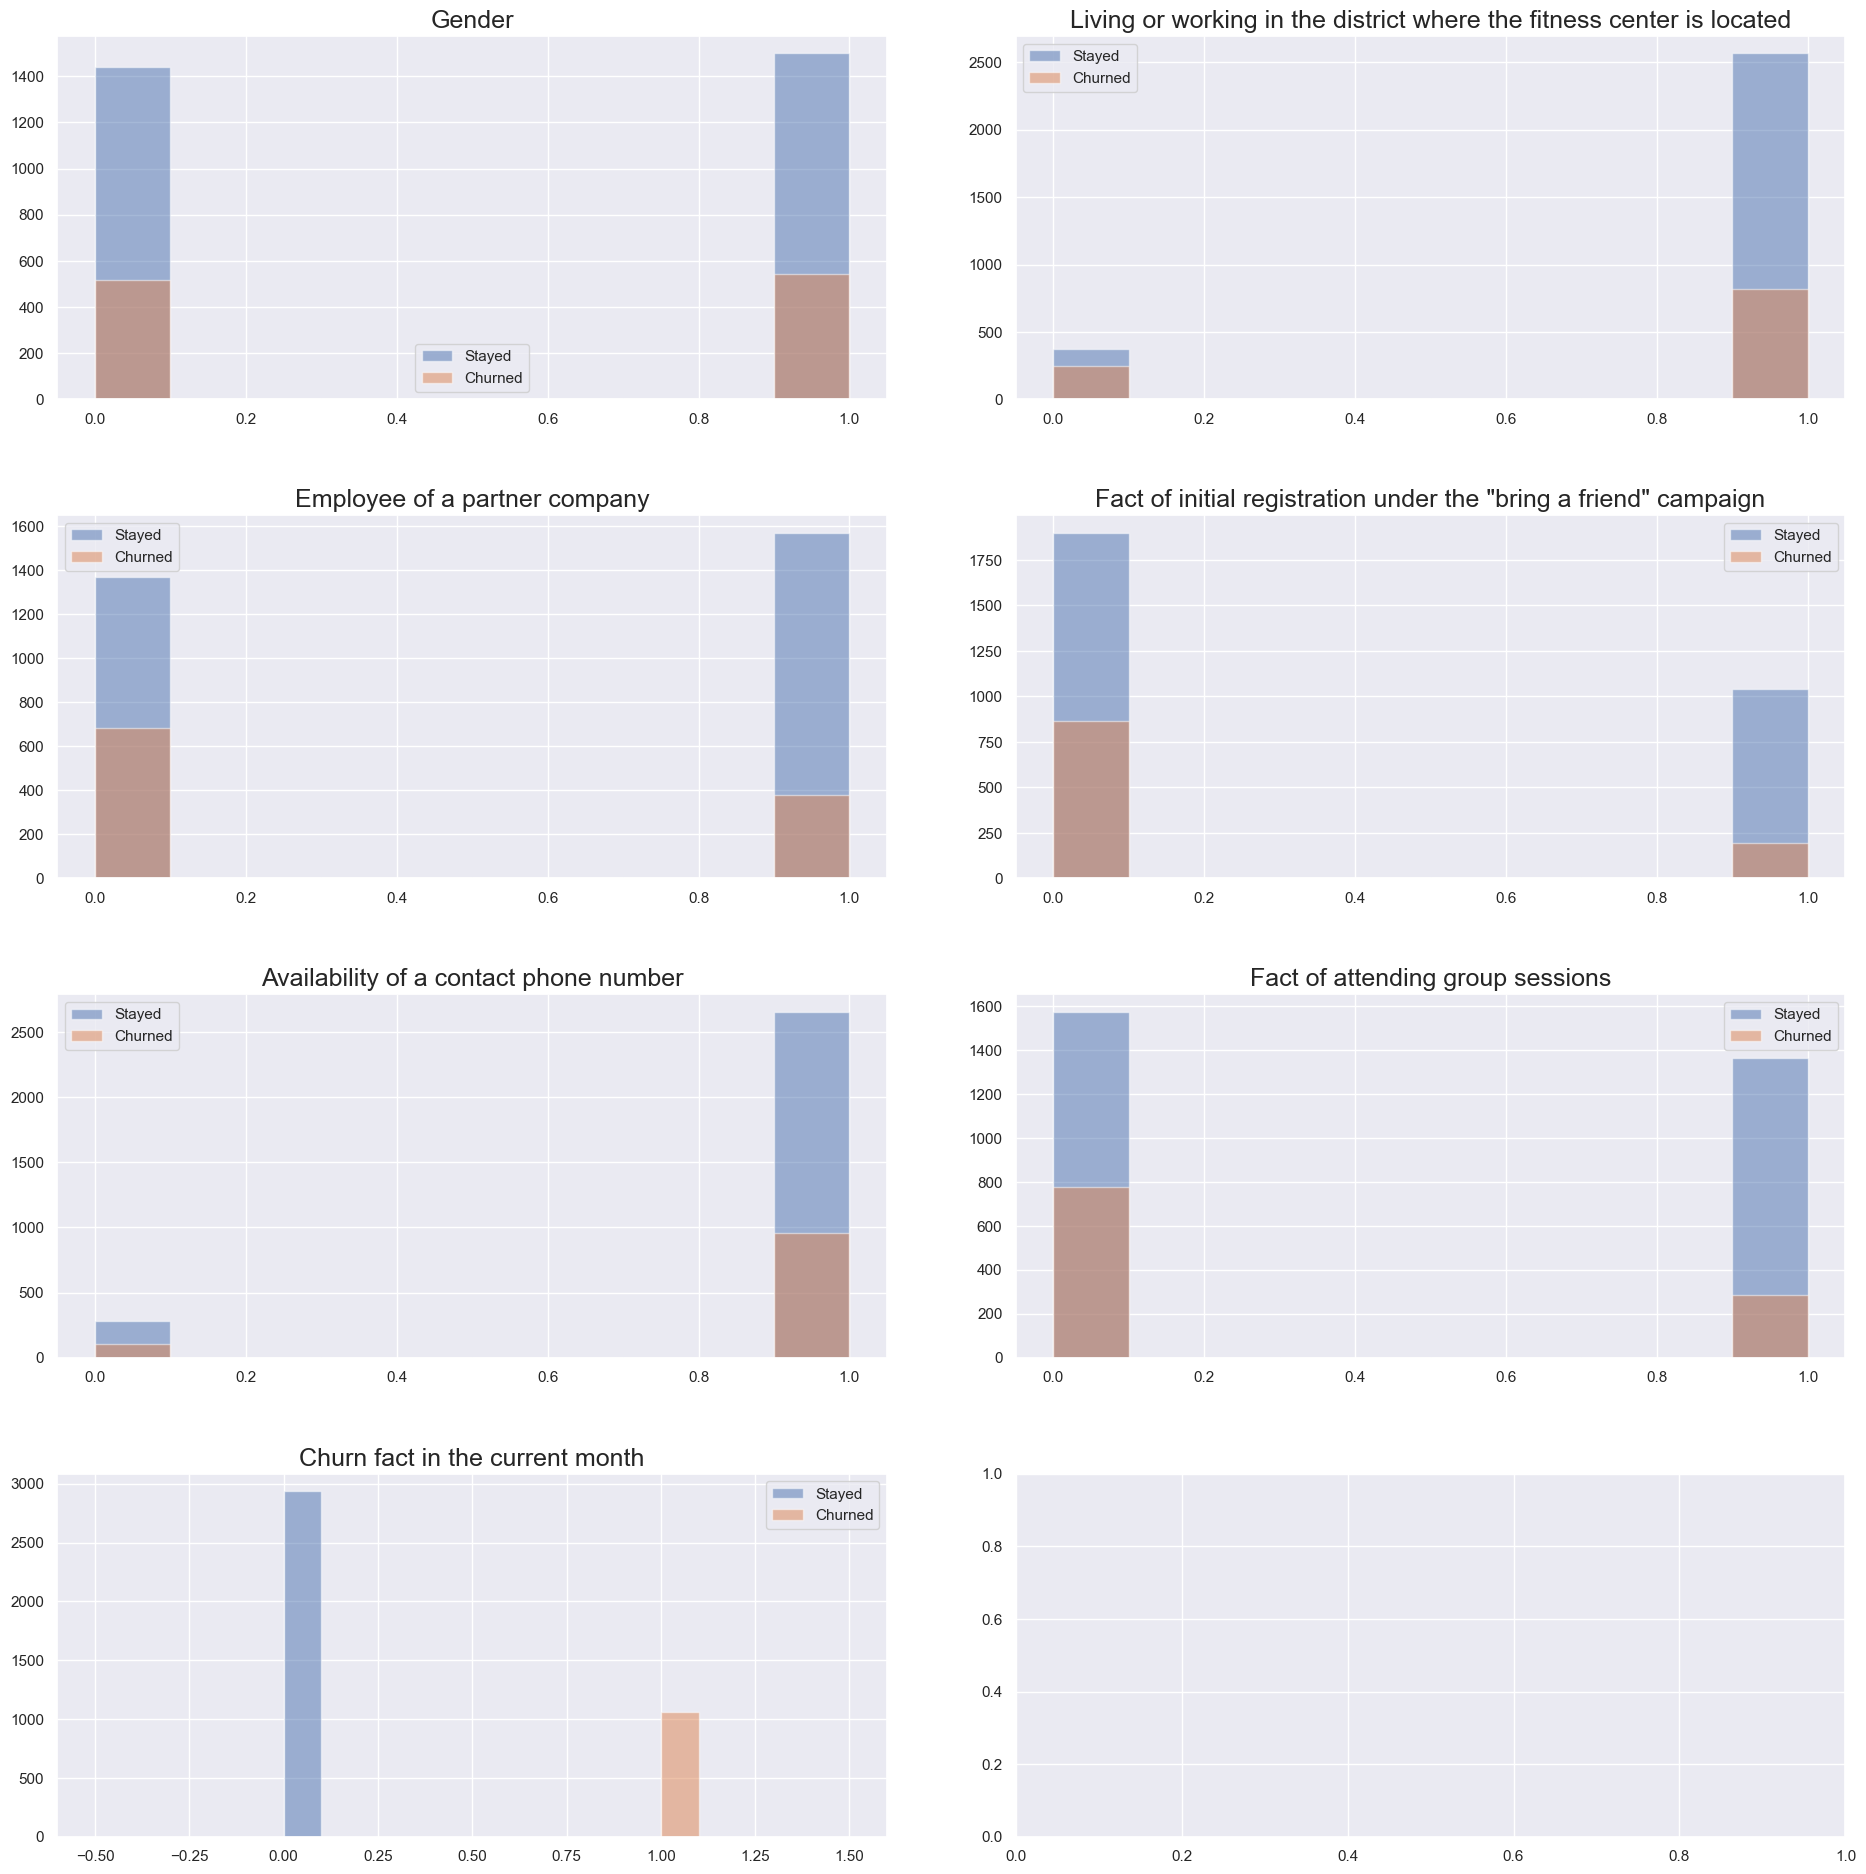

In [52]:
# Select the columns to exclude from the plot.
exclude_columns = [
    'Contract_period', 'Age', 'Avg_additional_charges_total',
     'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 
     'Avg_class_frequency_current_month'
]

# Select only those columns which are not in the exclude list.
plot_columns = [col for col in data.columns if col not in exclude_columns]

# List of title names for the plots.
title_list = [
    'Gender', 
    'Living or working in the district where the fitness center is located', 
    'Employee of a partner company', 
    'Fact of initial registration under the "bring a friend" campaign',
    'Availability of a contact phone number',
    'Fact of attending group sessions',
    'Churn fact in the current month',
    'not used'
]

# Define a 4x2 subplot layout.
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
fig.tight_layout(pad=5.0)

# For each subplot, plot histograms for customers who churned and who stayed.
for i, ax in enumerate(axs.flat[:len(plot_columns)]):
    ax.set_title(title_list[i], fontsize=18)
    
    # Plot for customers who stayed.
    data[data['Churn']==0][plot_columns[i]].hist(ax=ax, alpha=0.5)
    
    # Plot for customers who churned.
    data[data['Churn']==1][plot_columns[i]].hist(ax=ax, alpha=0.5)
    
    ax.legend(['Stayed', 'Churned'])

plt.show()

**The following conclusions can be drawn from the evaluation of the graphs:**

1. Among the customers who left, most of them were not employees of the fitness club partner company.

2. Most of the customers who left did not participate in the "Bring a Friend" promotion.

3. Most of the customers who left had current subscriptions for less than __1 month__. __Fewer than 10%__ of the clients who left had 12-month subscriptions.

4. Among those who attended group exercise classes, subscription cancellation was __50-60%__. Among those who did not attend group exercise classes, churn was __25-30%__.

5. The median age of clients who opted out of the fitness center was __27 years__ and the median age of those who did not opt out was 30 years.

6. The median total revenue from other fitness center services was higher for clients who did not quit.

7. The time to the end of the current subscription was __1 month__ for most of the customers who left.

8. The time from first contact with the fitness center to the end of the current subscription was __1-2 months__ for quit customers and __more than 3 months__ for non-quit customers.

9. The average frequency of visits to the fitness center per week for most refusal clients was __1.5 times per week__ and for those who did not give up their subscription was __2.5 times per week__.

10. The average number of visits to the fitness center per week over the past month is lower for clients who opted out than for those who did not opt out.

<a id="num23"></a>
### 2.3 Trait Correlation Matrix

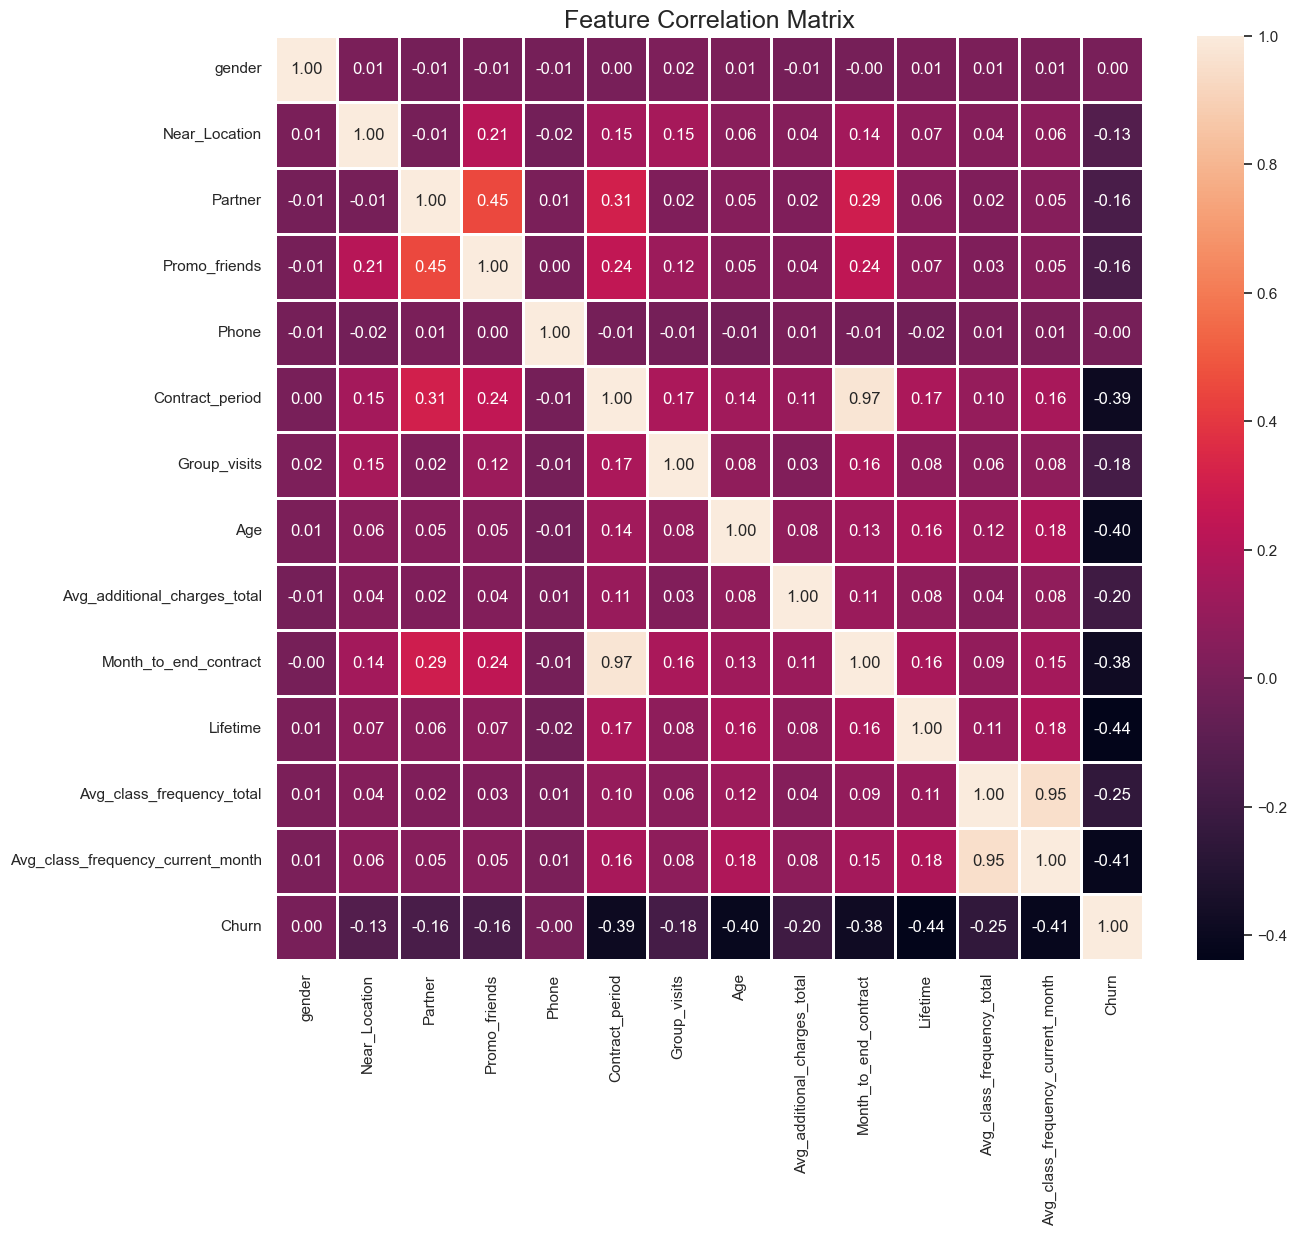

In [53]:
# Build a correlation matrix.
corr_matrix = data.corr()

# Create a heatmap of the correlation matrix.
plt.figure(figsize=(14, 12))

# Set the title.
plt.title('Feature Correlation Matrix', fontsize=18)

# Draw the heatmap.
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=1, linecolor='white')

# Display the plot.
plt.show()

**Conclusion:**

* Looking at the correlation matrix, we see that there are several factors associated with client churn. The most correlated factors with churn are 'lifetime' (i.e. how long they have been a client), 'age', and 'avg_class_frequency_current_month' (i.e. how often they have been going to the gym in the last month). All these factors have negative correlation with churn indicating that the longer a person has been a client, the older they are, and the more frequently they visit the gym in the current month, the less likely they are to stop their gym membership.

* On the other hand 'Contract_period' and 'Month_to_end_contract' are also negatively correlated with churn, implying that customers with longer contracts (and thus longer time till their contract ends) are less likely to churn. This could be due to the fact that these clients are more committed to their fitness routine or have a more long-term view on their gym membership.

* Finally, people who visit the gym as part of a promo deal or partner scheme ('Partner', 'Promo_friends') are also less likely to churn, indicating that these kind of incentives are effective in retaining customers.

In summary, the major factors contributing to client churn are lifetime, age, frequency of gym visits, length of membership contracts, and involvement in promotional programs.

<a id="num3"></a>
## 3. Build a customer churn forecasting model

Let's build a binary customer classification model, where the target feature is the fact of customer churn in the next month:

Split the data into training and validation samples by __train_test_split()__.

Let's train the model on the training sample in two ways:

* logistic regression,
* random forest.

Evaluate accuracy, precision and recall metrics for both models on the validation sample. Compare the models and determine the best model.

<a id="num31"></a>
### 3.1 Model training: Logistic regression

In [54]:
# Split data to features (matrix X) and target variable (y)
X, y = data.drop('Churn', axis=1), data['Churn']

# Split the data into a training set and a testing set with a 4:1 ratio, and using stratification to ensure proportionate representation of the target variable in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# Initialize the StandardScaler for normalization
scaler = StandardScaler()

# Normalize the training data using standard scaler and fit it at the same time
X_train_scaled = scaler.fit_transform(X_train)

# Normalize the test data using the same scaler for consistency and to avoid data leakage
X_test_scaled = scaler.transform(X_test)

# Initialize the LogisticRegression model with the 'lbfgs' solver
log_model = LogisticRegression(random_state=0, solver='lbfgs')

# Train the model with the scaled training data
log_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the test data
log_pred = log_model.predict(X_test_scaled)

<a id="num32"></a>
### 3.2 Model Training: Random Forest

In [55]:
# Create a Random Forest Classifier model class.
rf_model = RandomForestClassifier(n_estimators = 150, bootstrap = True, max_depth=12, max_features=12, random_state=0)

# Train the Random Forest model using the training data.
rf_model.fit(X_train, y_train)

# Use the trained model to make predictions on the validation sample.
forest_pred = rf_model.predict(X_test)

<a id="num33"></a>
### 3.3 Comparison of prediction quality of trained models

The following model metrics should be compared to evaluate the quality of the resulting predictions and select the best model:
* __Accuracy__ - Proportion of correct answers
* __Precision__ - Model accuracy
* __Recall__ - Completeness of the model

In [56]:
# Calculate metrics for Logistic Regression model.
accuracy_log = accuracy_score(y_test, log_pred)
precision_log = precision_score(y_test, log_pred)
recall_log = recall_score(y_test, log_pred)

# Display the calculated metrics.
print('Logistic Regression model')
print('Accuracy Metric:', '{:.2f}%'.format(accuracy_log))
print('Precision Metric:','{:.2f}%'.format(precision_log))
print('Recall Metric:', '{:.2f}%'.format(recall_log))

Logistic Regression model
Accuracy Metric: 0.94%
Precision Metric: 0.90%
Recall Metric: 0.85%


In [57]:
# Calculate metrics for Random Forest Classifier model.
accuracy_forest = accuracy_score(y_test, forest_pred)
precision_forest = precision_score(y_test, forest_pred)
recall_forest = recall_score(y_test, forest_pred)

# Display the calculated metrics.
print('Random Forest Classifier model')
print('Accuracy Metric:', '{:.2f}%'.format(accuracy_forest))
print('Precision Metric:', '{:.2f}%'.format(precision_forest))
print('Recall Metric:', '{:.2f}%'.format(recall_forest))

Random Forest Classifier model
Accuracy Metric: 0.93%
Precision Metric: 0.87%
Recall Metric: 0.85%


**Conclusion:**

The performed analysis shows that both the Logistic Regression model and the Random Forest Classifier model perform well in predicting customer churn.

The Logistic Regression model demonstrated slightly better results in terms of Accuracy and Precision (94% and 90% respectively) compared to the Random Forest model (93% and 87% respectively). However, both models showed the same level of Recall (85%).

Accuracy measures how correctly the models made predictions. Precision tells us how many of the correctly predicted cases actually turned out to be positive, while Recall tells us how many of the actual positive cases were correctly predicted by the model.

Thus, the **Logistic Regression model might be considered the better model** for this case as it demonstrated slightly higher Accuracy and Precision rates.

<a id="num4"></a>
## 4. Clustering of fitness center clients

In order to divide clients into groups based on different attributes and identify clients with the highest risk of leaving, it is necessary to carry out a process of client clustering. To do this, it is necessary to calculate a matrix of distances between all attributes using linkage classes.

<a id="num41"></a>
### 4.1 Data standardization and dendrogram construction

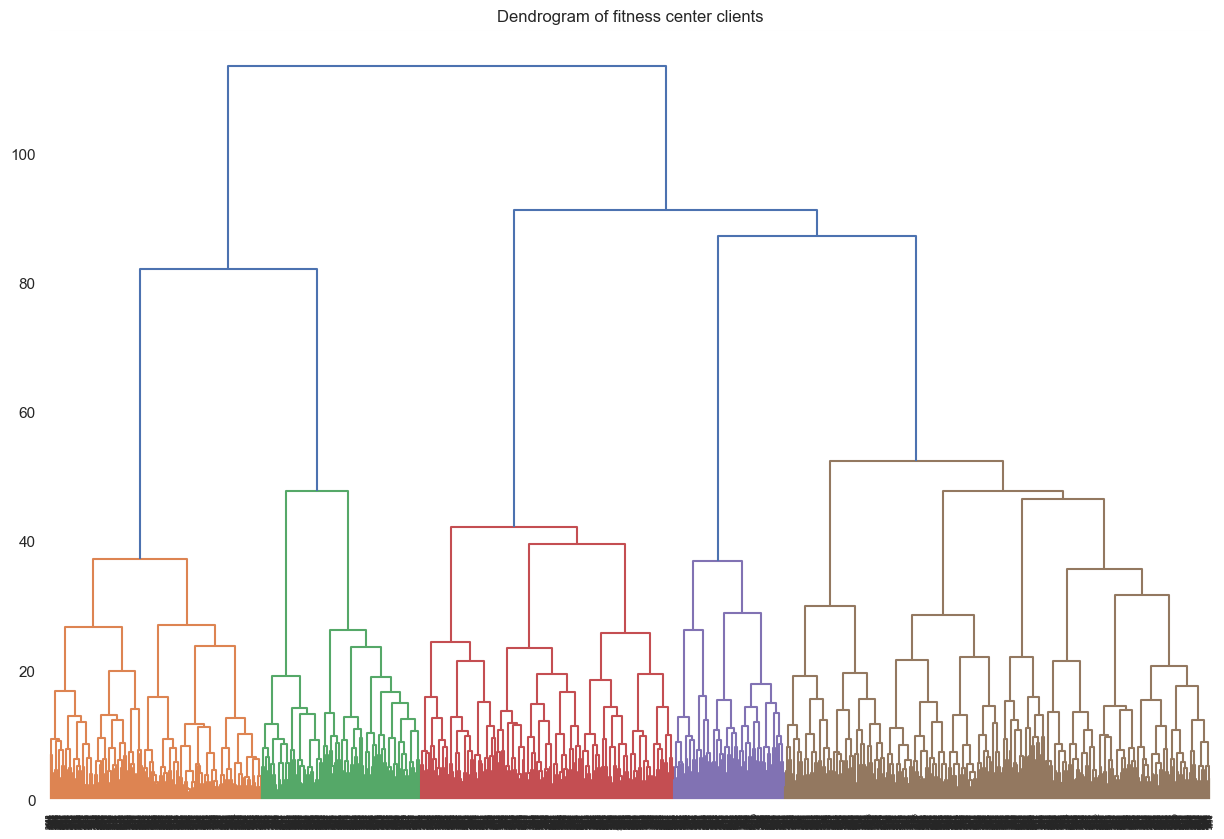

In [58]:
# Create a Scaler object.
scaler = StandardScaler()

# Fit the scaler and transform the data set.
standart_data = scaler.fit_transform(data)

# Calculate the distance matrix.
linked = linkage(standart_data, method = 'ward')

# Plot the dendrogram.
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Dendrogram of fitness center clients')
plt.show()

**Conclusion:**

As can be seen from the dendrogram, __5 clusters__ can be distinguished. 

<a id="num42"></a>
### 4.2 Training a clustering model based on the K-Means algorithm

In [59]:
# Create a StandardScaler object.
scaler = StandardScaler()

# Fit and transform the data with the Scaler.
standart_data = scaler.fit_transform(data)

# Initialize a KMeans model with 5 clusters.
km = KMeans(n_clusters = 5, random_state=1)

# Apply the KMeans model to the data, resulting in an array of cluster predictions.
cluster_data = km.fit_predict(standart_data)

# Assign each row in the dataframe the corresponding cluster number.
data['cluster_km'] = cluster_data

# Calculate mean column values for each cluster.
# Reset index for better formatting.
cluster_features = data.groupby('cluster_km').mean().reset_index()

# Format values of Styler object to show only two decimal points.
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).format("{:.2f}")

,0,1,2,3,4
cluster_km,0.00,1.00,2.00,3.00,4.00
gender,0.56,0.52,0.46,0.51,0.52
Near_Location,0.84,0.88,0.82,0.76,0.98
Partner,0.35,0.55,0.41,0.34,0.92
Promo_friends,0.21,0.00,0.20,0.18,1.00
Phone,0.91,0.89,0.91,0.90,0.90
Contract_period,2.44,11.75,2.39,1.52,9.98
Group_visits,0.45,0.50,0.38,0.26,0.57
Age,30.00,29.92,30.04,26.94,29.86
Avg_additional_charges_total,157.72,164.67,154.43,114.49,159.00


The provided output shows the mean characteristics of five different client clusters.

Based on the data:

* Cluster 4 has the highest rate of clients that live near the fitness center, with 98% of clients residing or working nearby. This suggests that customers prefer to visit fitness centers in their local area.

* Cluster 1 and 4 have the highest number of clients who are employees of partner companies, with 55% and 92% respectively.

* Interestingly, only clients from cluster 4 have joined the fitness center under the "bring a friend" promo. This could indicate a higher level of satisfaction or motivation to workout among these clients.

* All clusters have high percentages of customers with contact phones, which suggests good client communication in all clusters.

* Customers in cluster 1 and 4 have the longer contracts, with an average of 11.75 and 9.98 months. They also have the longest time until their current contract ends. This could indicate a higher level of commitment to the fitness center in these clusters.

* Clients from cluster 4 have the highest rate of group visits (57%), followed by clients from cluster 1 and 0. This can suggest that they are more involved in community building activities at the fitness center.

* The average age of clients remains fairly consistent across all clusters, hovering around 30 years old.

* Cluster 1 has the highest average total of additional charges at 164.67, while cluster 3 spends the least at 114.49. This suggests that customers from cluster 1 are more willing to spend on secondary services offered by the fitness center.

* Customers from cluster 3 have the lowest lifetime at the fitness center, indicating a higher client turnover rate.

* Average weekly visits are notably highest for clients in cluster 0 and notably lowest in cluster 3.

* Clients from cluster 3 also showed highest churn rate at 100%, indicating a severe retention problem for this group of clients at the fitness center.

Overall, this data suggests that there are several distinct groups of customers at this fitness center, with some showing much higher levels of engagement and commitment (clusters 0, 1, and 4), while others seem less engaged and more likely to stop their membership (cluster 3).

**Let's visualize the obtained table with average values of cluster features.**

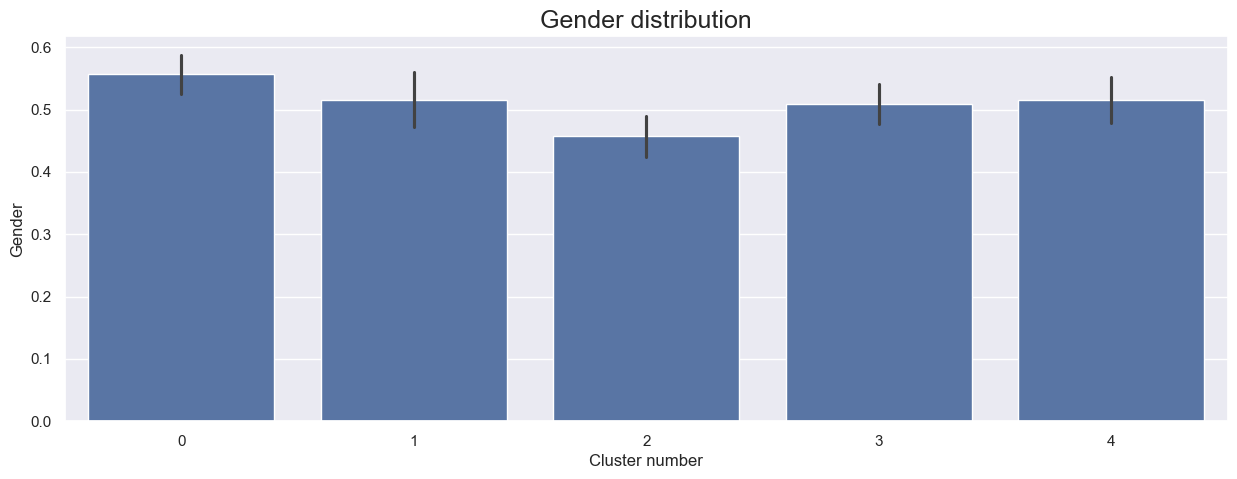

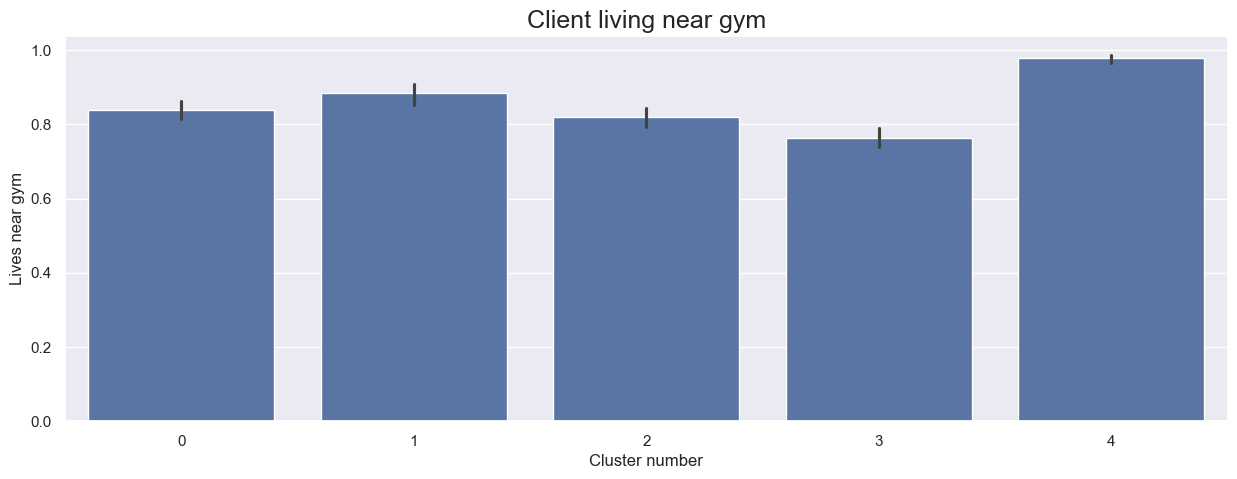

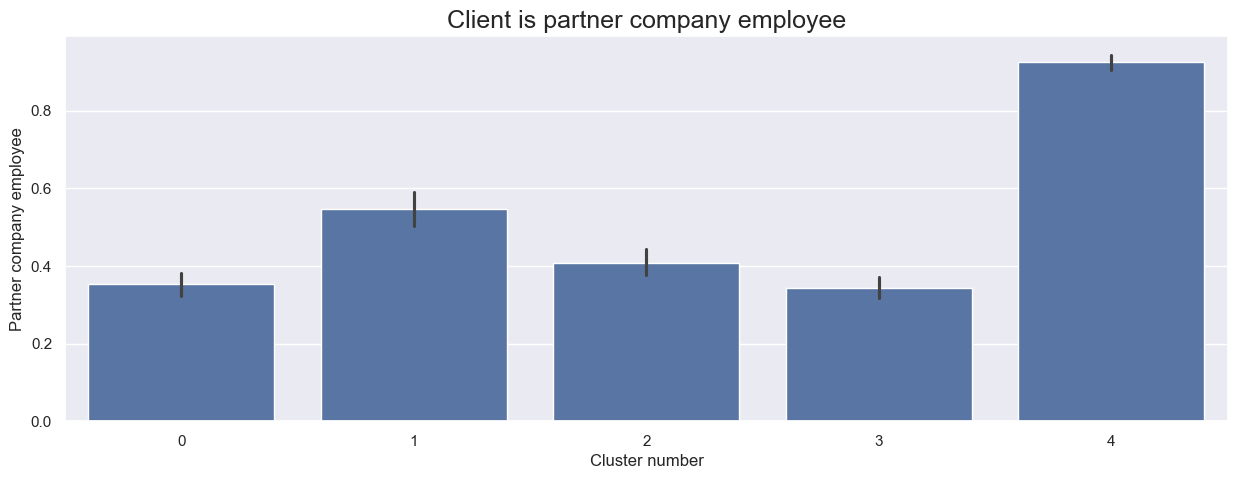

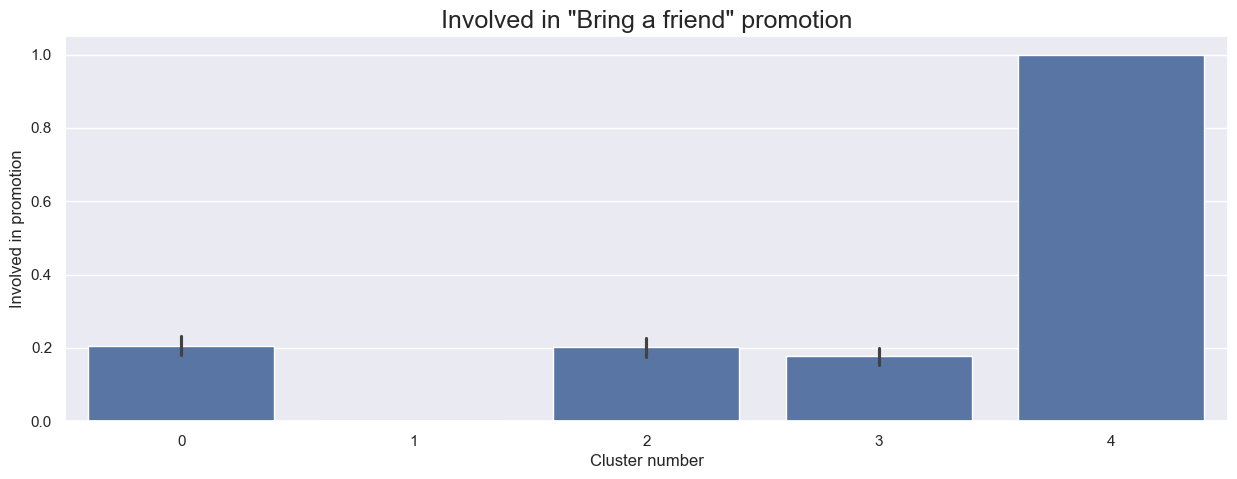

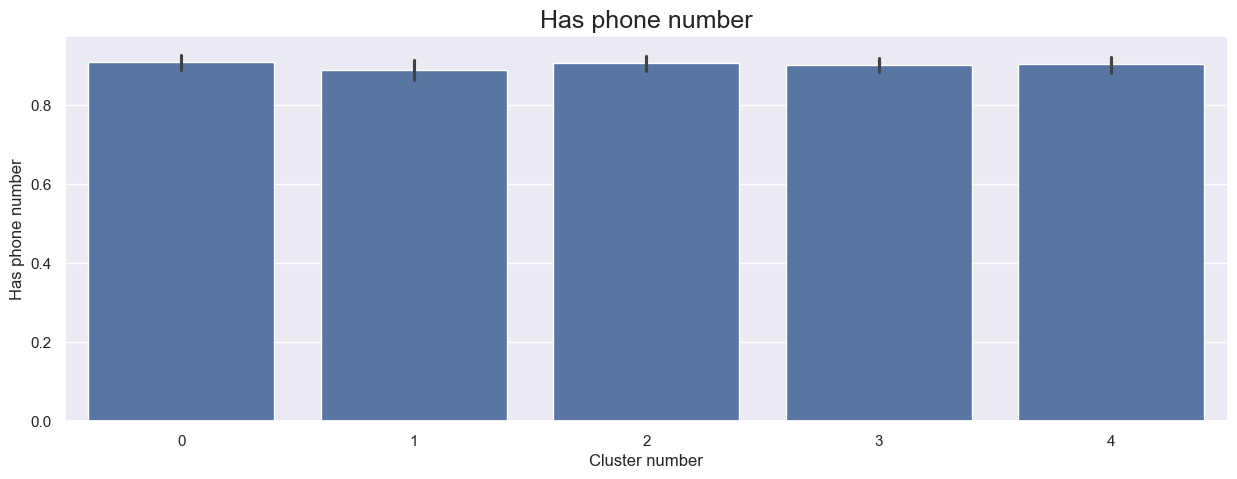

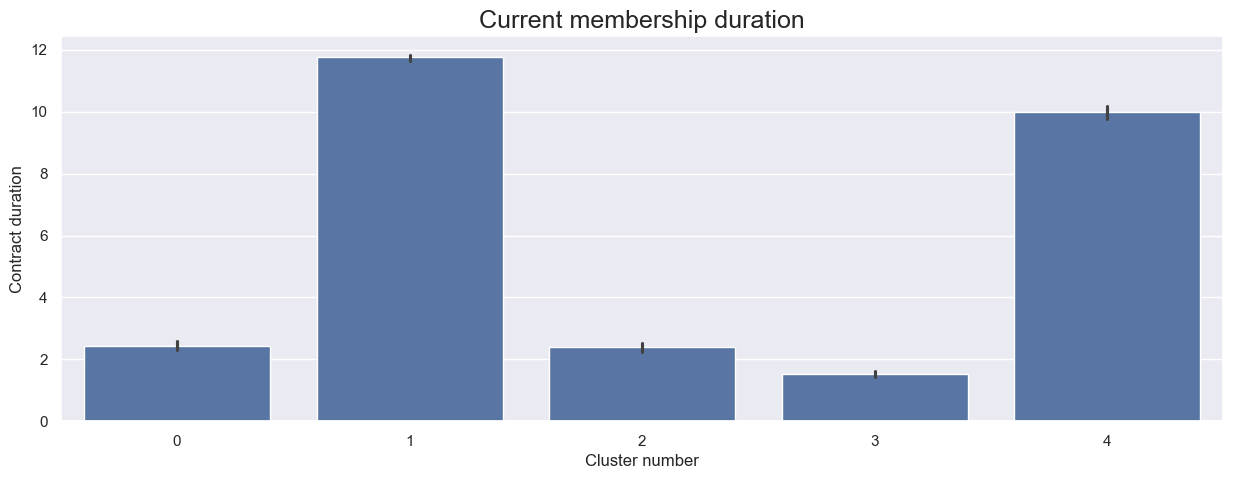

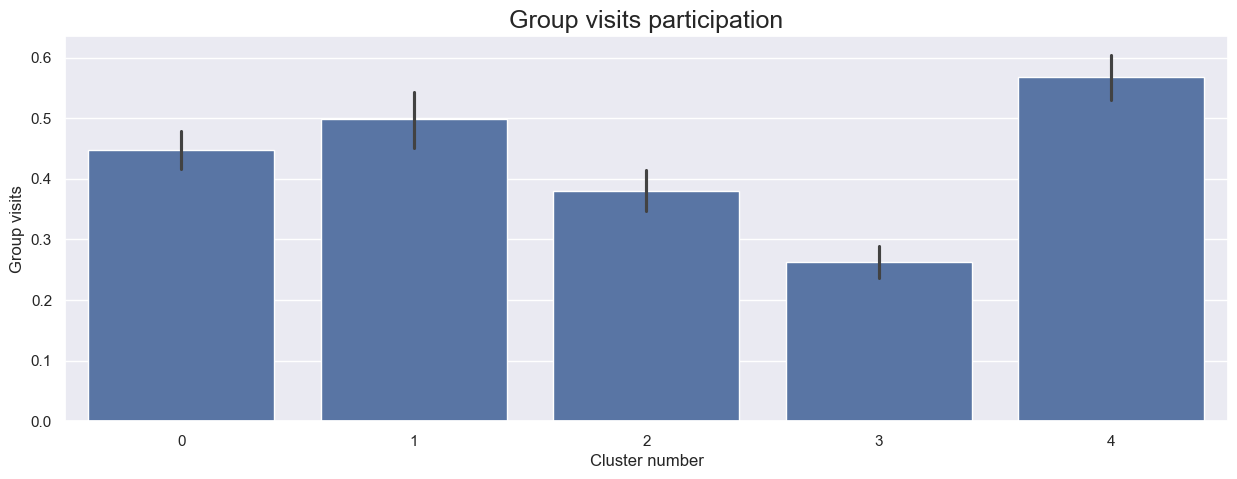

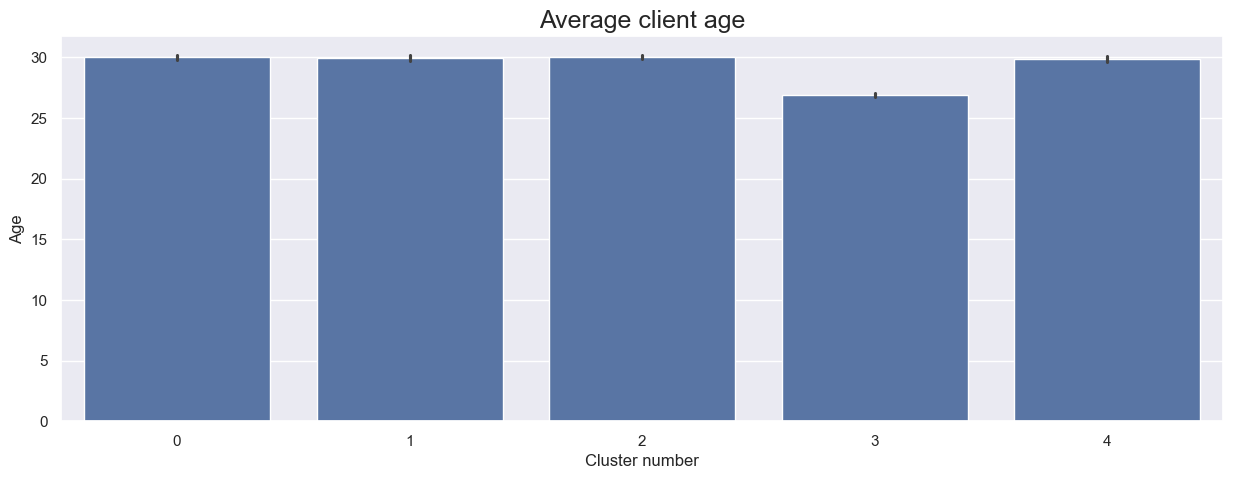

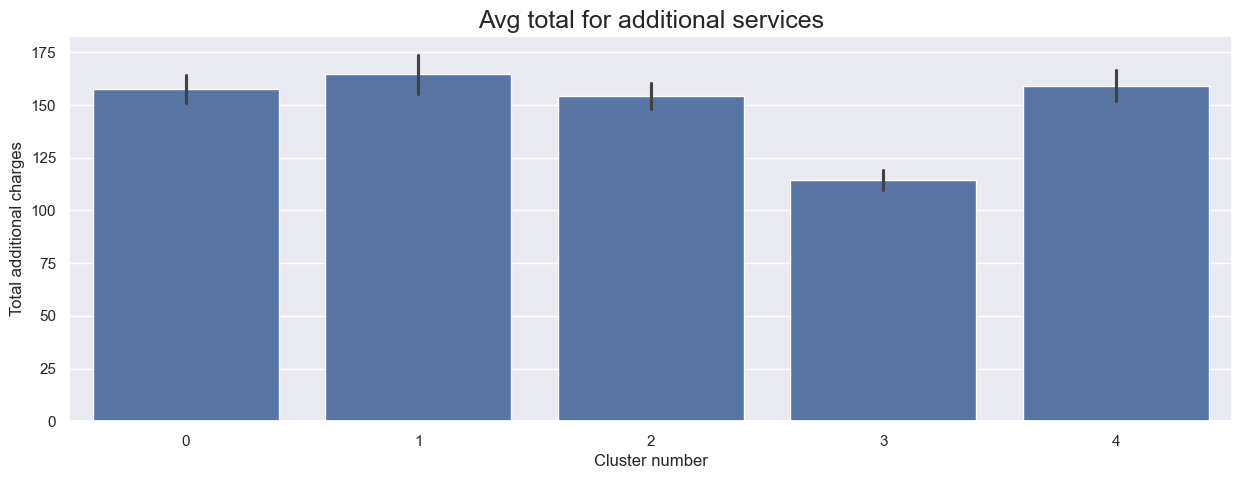

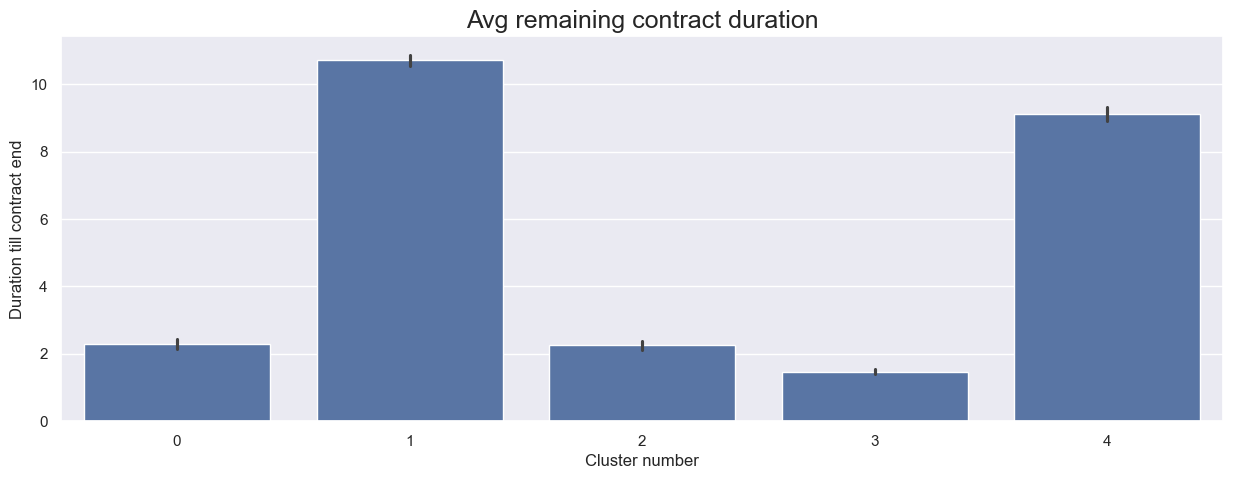

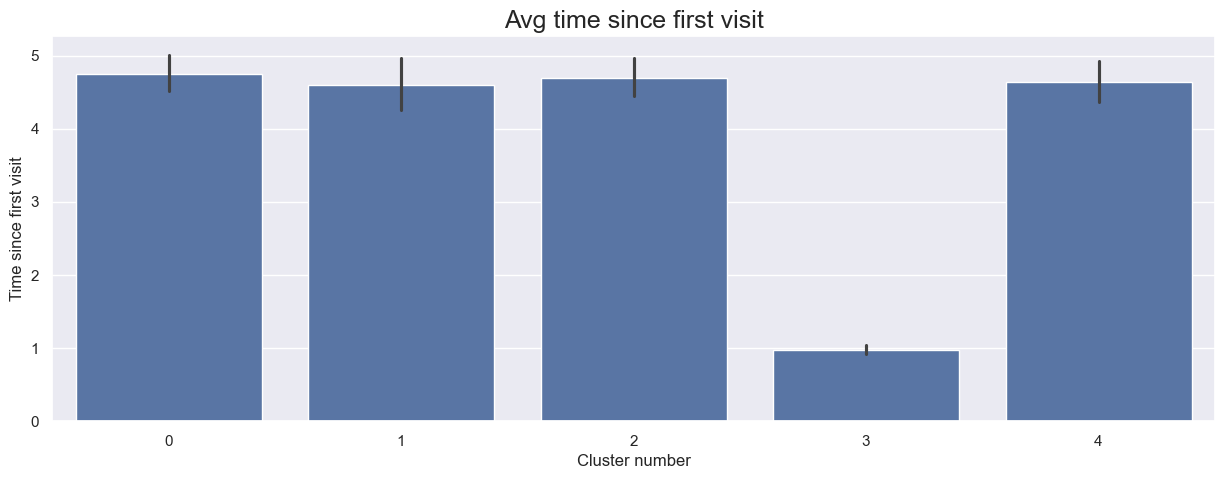

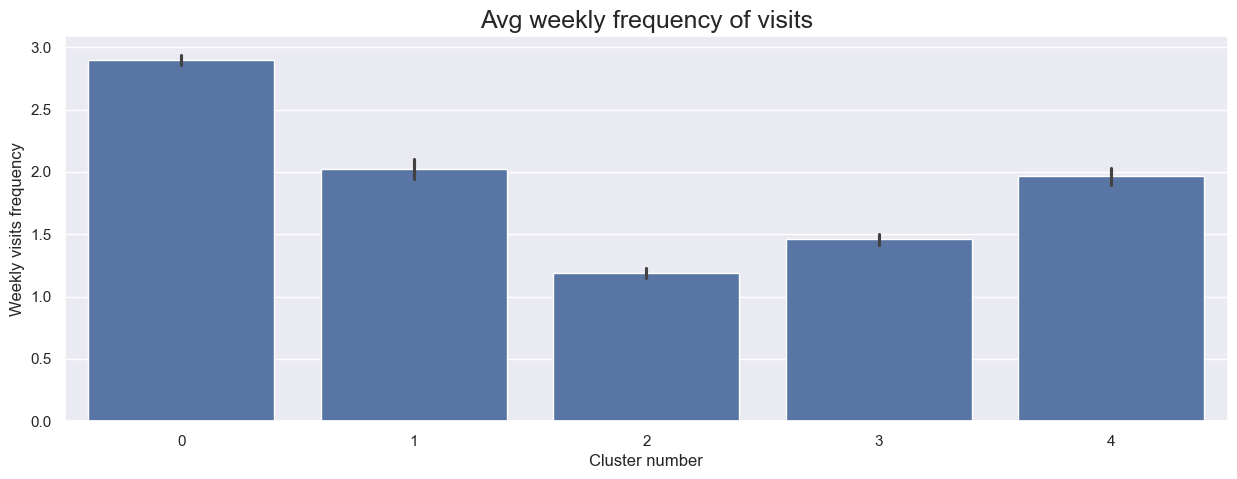

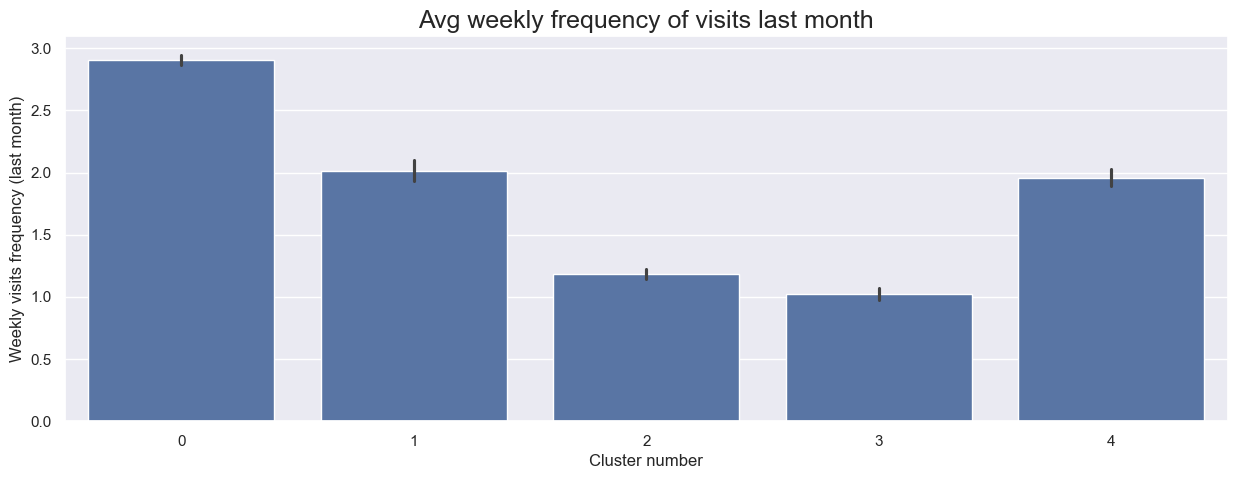

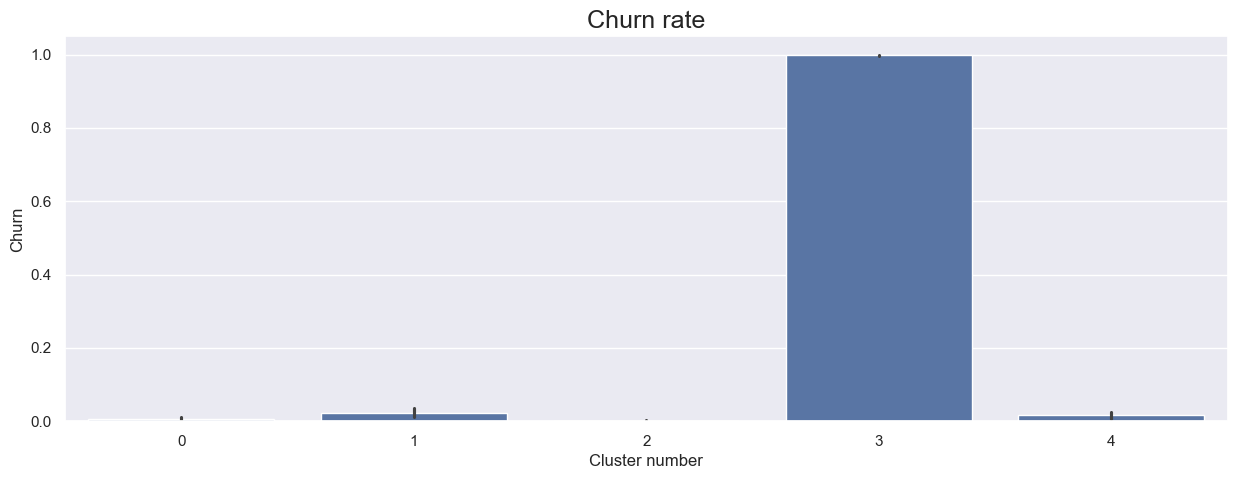

In [60]:
# Data column names
column_list = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 
               'Contract_period', 'Group_visits', 'Age', 'Avg_additional_charges_total', 
               'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 
               'Avg_class_frequency_current_month', 'Churn']
               
# Graph titles
title_list = ['Gender distribution', 'Client living near gym', 'Client is partner company employee', 
              'Involved in "Bring a friend" promotion', 'Has phone number', 'Current membership duration', 
              'Group visits participation', 'Average client age', 'Avg total for additional services', 
              'Avg remaining contract duration', 'Avg time since first visit', 
              'Avg weekly frequency of visits', 'Avg weekly frequency of visits last month', 'Churn rate']

# Y-axis labels               
ylabel_list = ['Gender', 'Lives near gym', 'Partner company employee', 'Involved in promotion', 
               'Has phone number', 'Contract duration', 'Group visits', 'Age', 
               'Total additional charges', 'Duration till contract end', 
               'Time since first visit', 'Weekly visits frequency', 
               'Weekly visits frequency (last month)', 'Churn']

# Loop to create the barplot graphs
for i in range(len(column_list)):
    plt.figure(figsize = (15, 5))
    # Set title 
    plt.title(title_list[i], fontsize=18)
    # Set x and y labels
    sns.barplot(x='cluster_km', y=column_list[i], data=data).set(xlabel='Cluster number', ylabel=ylabel_list[i])
    plt.show()

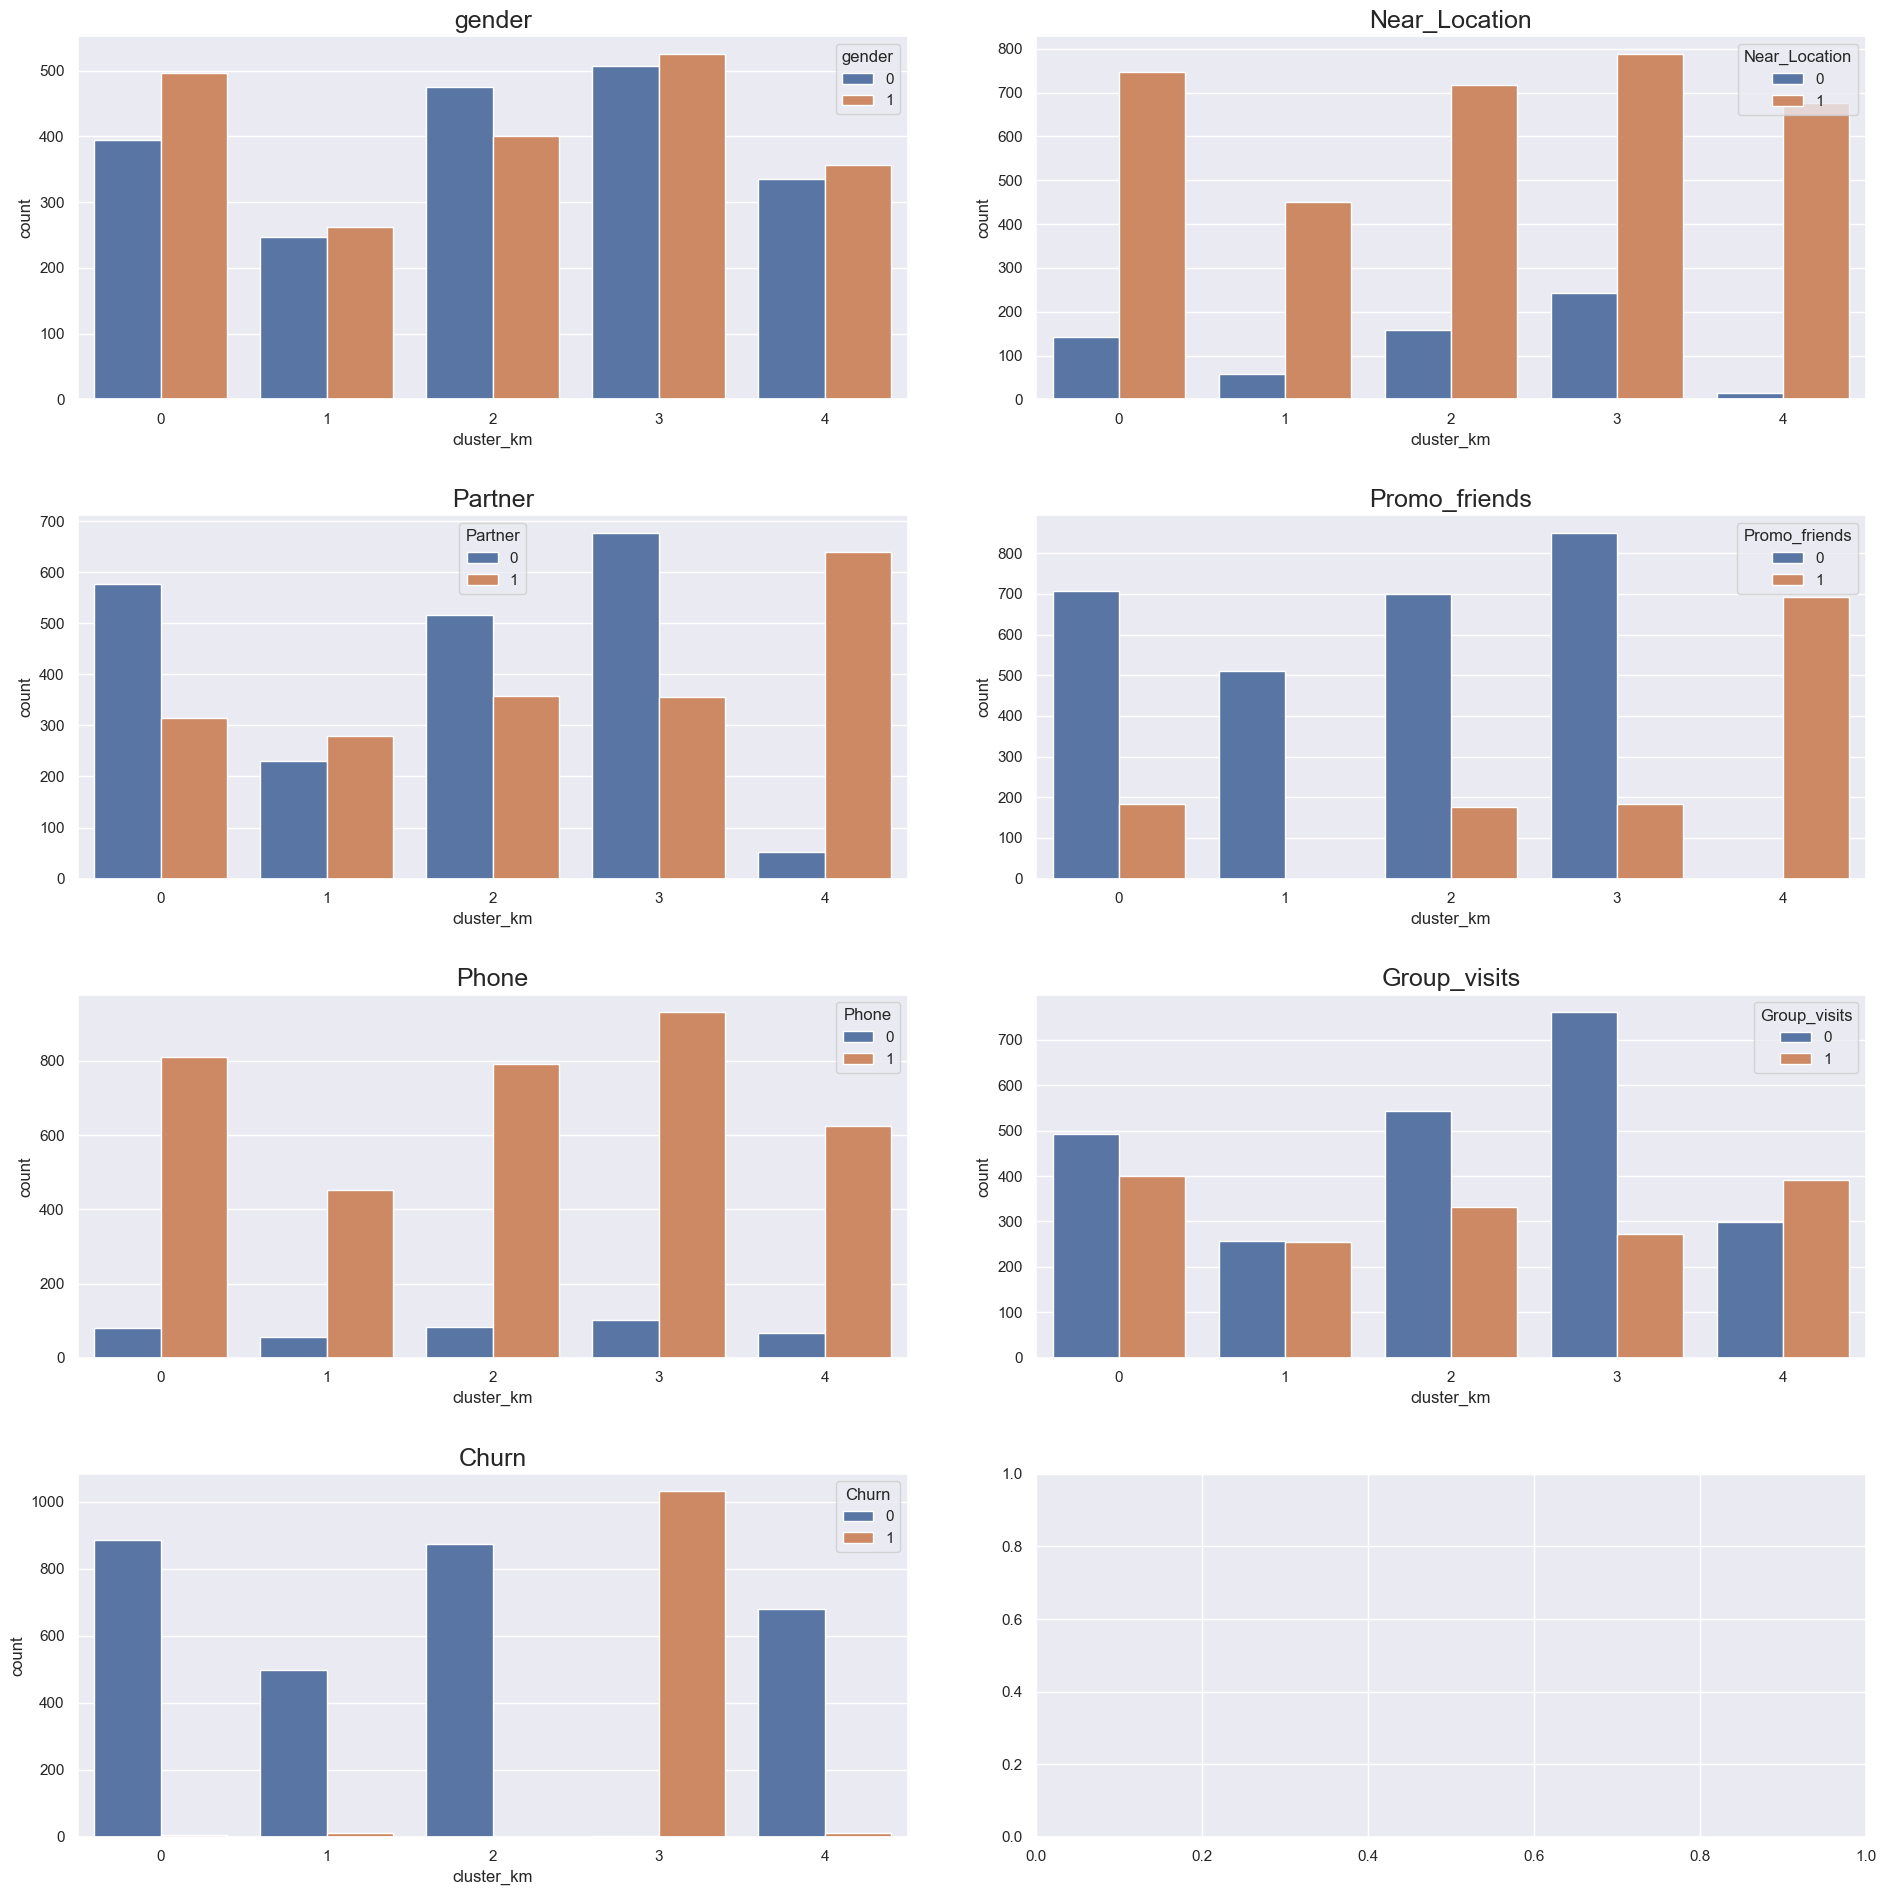

In [61]:
# List of categorical column names
discret_list = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 
                'Phone', 'Group_visits', 'Churn']

# List of non-categorical column names
not_dis_list = [column for column in column_list if column not in discret_list]

# Create figure with subplots; adjusting figure size and padding between plots
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
fig.tight_layout(pad=5.0)

# Enumerate() allows us to loop over something and have an automatic counter
# With zip() we combine two (or more) lists into a sequence of tuples
for i, ax in enumerate(axs.flat):
    # Check if we still have a column to plot
    if i < len(discret_list):
        # Set the plot title
        ax.set_title(discret_list[i], fontsize=18)
        # Create a count plot with categorical data
        sns.countplot(data=data, x='cluster_km', hue=discret_list[i], ax=ax)

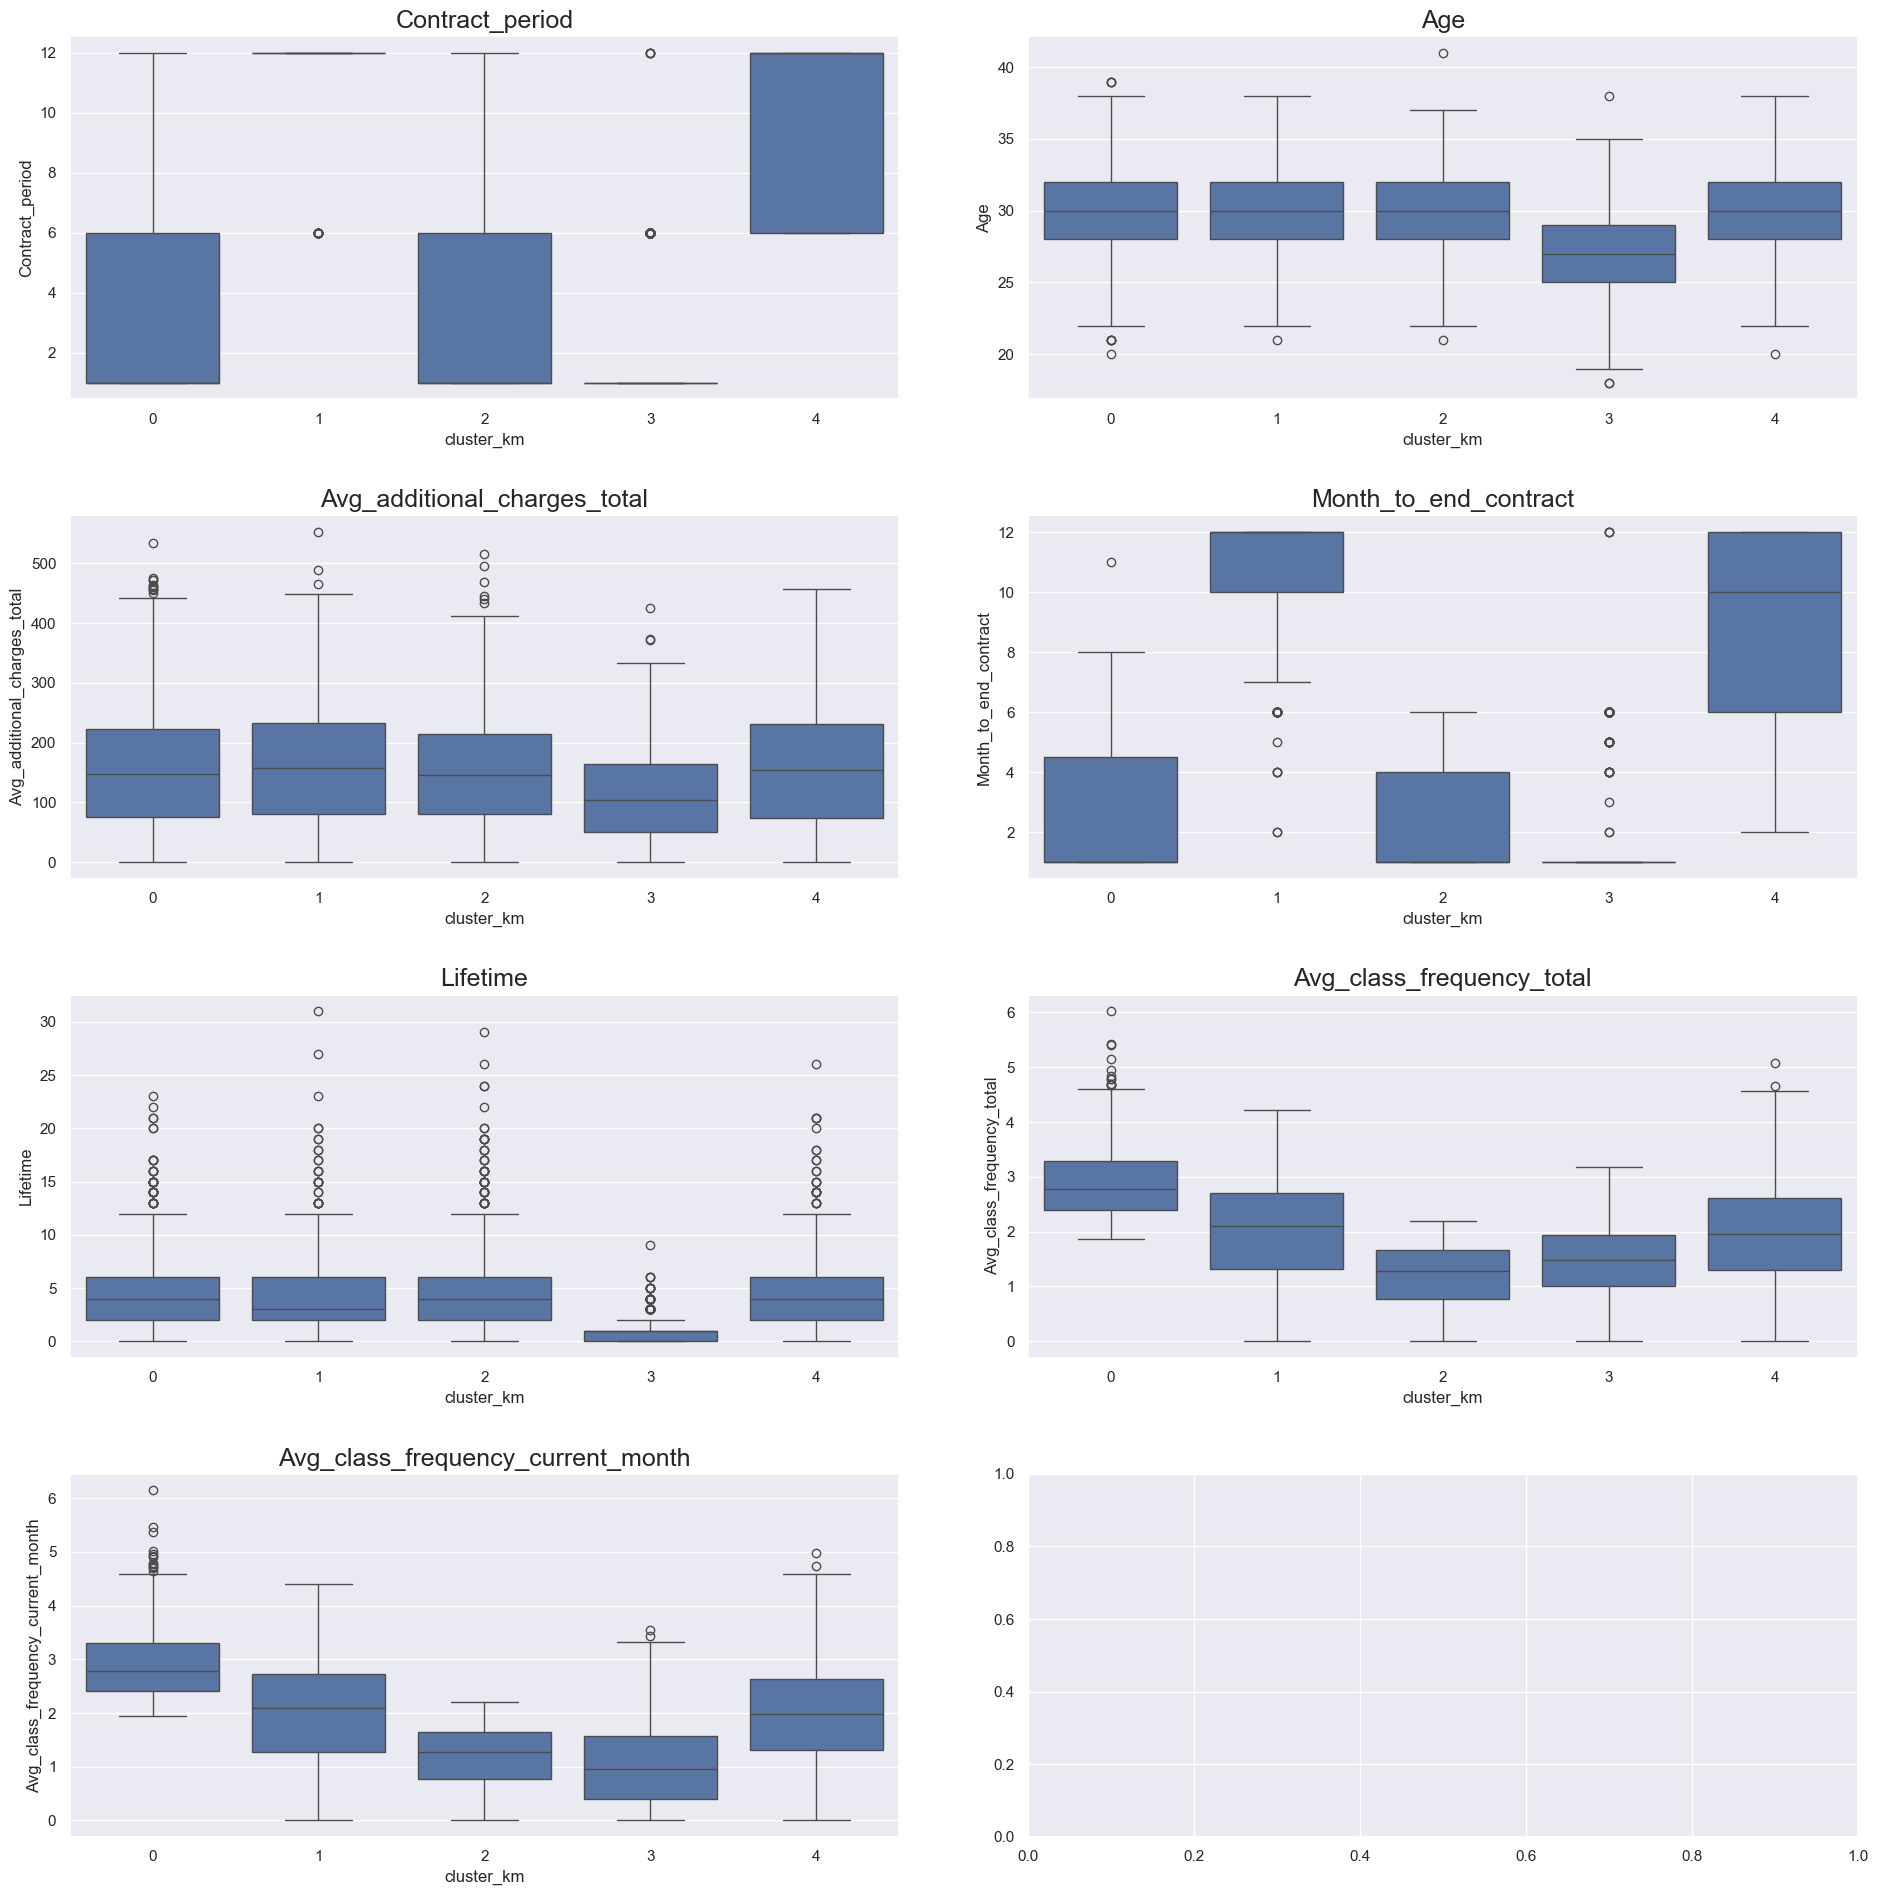

In [62]:
# Create figure with subplots, adjusting figure size and padding between plots
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
fig.tight_layout(pad=5.0)

# Enumerate() allows us to loop over something and have an automatic counter
# With zip() we combine two (or more) lists into a sequence of tuples
for i, ax in enumerate(axs.flat):
    # Check if we still have a column to plot
    if i < len(not_dis_list):
        # Set plot title
        ax.set_title(not_dis_list[i], fontsize=18)
        # Create boxplot with non-categorical data
        sns.boxplot(data=data, x='cluster_km', y=not_dis_list[i], ax=ax)

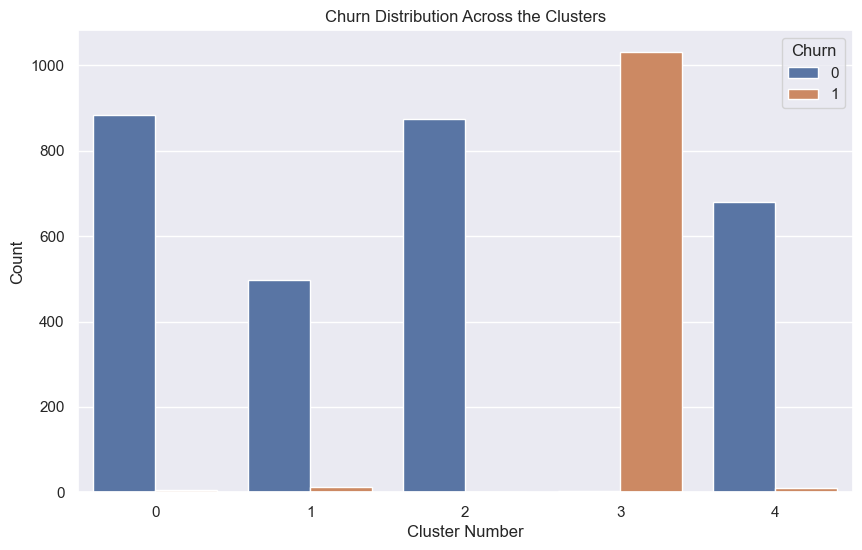

In [63]:
# Calculate the count of clients for each churn status in each cluster
churn_counts = data.groupby(['cluster_km', 'Churn']).size().reset_index(name='count')

# To create a visualization of the count of churn and non-churn clients in each cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_counts, x='cluster_km', y='count', hue='Churn')
plt.title('Churn Distribution Across the Clusters')
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.show()

In [64]:
churn_counts

,cluster_km,Churn,count
0,0,0,885
1,0,1,6
2,1,0,498
3,1,1,12
4,2,0,874
5,2,1,1
6,3,0,2
7,3,1,1031
8,4,0,680
9,4,1,11


**Based on the count of clients per churn status in each cluster:**

* Cluster 0 has a high retention rate with 885 clients staying and only 6 clients lost to churn.
* Similarly, in clusters 1, 2, and 4, the ratio of customer retention is high with 498, 874 and 680 clients retained in each cluster respectively. However, they have some level of churn with 12, 1, and 11 clients lost respectively.
* Cluster 3 stands out with an extremely high churn rate: out of 1033 clients, 1031 have churned and only 2 clients have stayed. This indicates a major issue in customer retention for this cluster and might necessitate immediate attention.

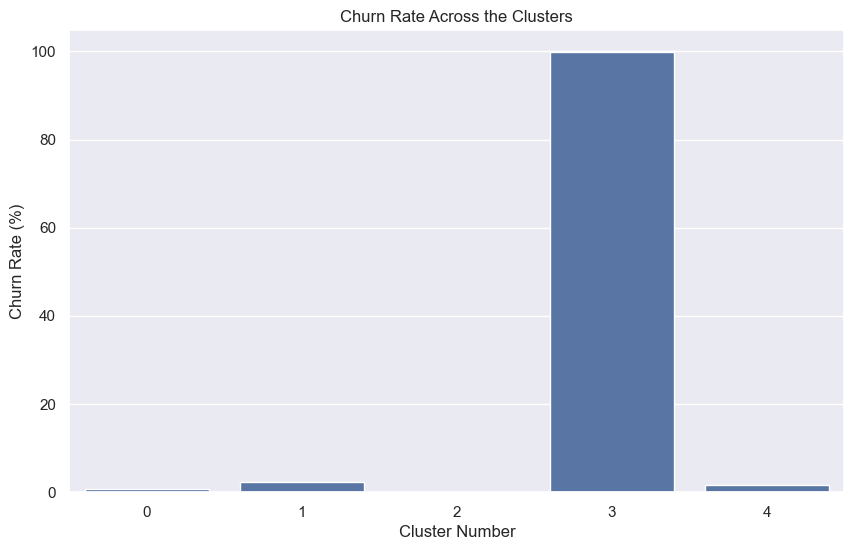

In [65]:
# Calculate the churn rate for each cluster
churn_rate = data.groupby('cluster_km')['Churn'].mean().reset_index()

# Add a new column to the dataframe representing the churn rate as a percentage
churn_rate['percent_churn'] = round(churn_rate['Churn'] * 100, 2)

# Create a bar plot to visualize the churn rate for each cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rate, x='cluster_km', y='percent_churn')
plt.title('Churn Rate Across the Clusters')
plt.xlabel('Cluster Number')
plt.ylabel('Churn Rate (%)')
plt.show()

In [66]:
churn_rate

,cluster_km,Churn,percent_churn
0,0,0.006734,0.67
1,1,0.023529,2.35
2,2,0.001143,0.11
3,3,0.998064,99.81
4,4,0.015919,1.59


**Conclusion:**

Based on the churn rate for each cluster:

* Cluster 3 shows an extremely high churn rate at 99.81%. This indicates that almost all of the clients in this cluster stopped their membership, suggesting major retention issues.
* Clusters 0, 1, 2, and 4 have significantly lower churn rates at 0.67%, 2.35%, 0.11%, and 1.59% respectively. This demonstrates that these clusters have a high level of customer stability and strong retention strategies.

**General conclusions of the section:**

Based on the provided data, we can discern specific characteristics for each cluster:

**Cluster 0** ("The Loyal Locals"): Clients in this cluster are likely nearby residents, with 84% living near the fitness center. These clients also have the highest average number of weekly visits (both total and in the last month). Their contract period is relatively short (2.44 months left on average), but they have one of the lowest churn rates (1%), which suggests a strong loyalty towards the fitness center.

**Cluster 1** ("The Partnered Patrons"): Half of the clients from this cluster are employees of partner companies and they also hold the longest contracts (11.75 months on average). They don't utilize the "bring a friend" promotion, but they have one of the lowest churn rates (2%) despite a moderate gym attendance rate.

**Cluster 2** ("The No-Frills Fitness Enthusiasts"): Quite similar to Cluster 0 in many ways, clients in this cluster don't seem to be brought in through partner companies or friend invitations. They are also on shorter contract periods, with similar near location, age, additional charges, contract period, and lifetime. However, they visit group sessions less and they have the lowest churn rate, only 0.11%.

**Cluster 3** ("The At-Risk Newbies"): This cluster is characterized by a notably younger average age (26.9 years old) and shorter lifetime (0.98 months on average). Despite the lower additional spending and average weekly attendance rates, this group has an extreme churn rate of nearly 100% which is a major concern.

**Cluster 4** ("The Social Butterflies"): Almost all of these clients live or work near the fitness center. They seem to be highly social, with every customer having been referred through a friend and a large proportion attending group visits. They also tend to sign longer contracts and have a low churn rate of 2%.

Each cluster shows a distinct behavior and, interestingly, those with longer contracts and partnership programs (clusters 1 and 4) have lower churn rates. Meanwhile, the cluster with the highest churn rate (cluster 3) consists primarily of newer, younger members who spend less and visit less frequently, indicating that engagement and investment in the fitness center’s programs and services are crucial factors for retaining customers.

<a id="num5"></a>
## 5. General conclusions and basic recommendations

The general conclusion from the data is that customer retention at a fitness center is significantly influenced by various factors including the customer's proximity to the center, social connections (either through friends or partner companies), participation in group activities, and their financial commitment (reflected in the contract length and spending on additional services). The fitness center's client base can be segmented into distinct groups based on these characteristics, each with its own loyalty level and churn rate. Notably, newer and younger members who engage less and invest less in the fitness center (reflected in lower attendance, shorter contracts, and less spending) are most likely to terminate their membership. On the other hand, clients that have stronger involvement and commitment, such as those living or working nearby, having connections through friends or partner companies, and signing longer contracts, tend to have higher retention rates. Understanding these behavioral patterns is key to developing effective customer retention strategies.



**Recommendations to the manager on client retention:**

**Boost engagement and interaction:** As seen from the analysis, clients who are more engaged are less likely to churn. Encouraging participation in fitness activities, offering group classes and providing facilities for clients to interact and share their experiences can work in favor of boosting client engagement and interaction.

**Loyalty Programs:** Offering loyalty programs such as discounts on renewal of memberships, referral rewards, and exclusive offers on using other fitness center’s services can incentivize customers to continue with their membership.

**Contracts:** Offering longer-term contracts may also be worth considering. As seen from the analysis, customers with longer contracts are significantly less likely to churn. These can be supplemented with attractive pricing packages for long-term contracts and potential discounts for upfront payment.

**Promotions:** 'Bring a friend' and 'partner' promotions can be effective in attracting and retaining customers. Providing incentives for these methods can not only increase the customer base but also help in maintaining customer loyalty.

**Personalize Communication:** Understanding the individual customer and tailoring communication based on their preferences can enhance the overall customer experience, thereby reducing the likelihood of churn. This can include checking in with customers who are no longer visiting, understanding their issues and offering personalized solutions.

**Attention to Cluster 2:** Special attention should be placed on clients in Cluster 3 who are early leavers as identified by our analysis. These customers are at a higher risk of churning. Apart from interaction and engagement activities, offers on renewals and personalized solutions can be considered for this group.

**Understanding Customer Feedback:** Finally, actively seeking and understanding customer feedback is critical. If customers are leaving due to unmet needs or dissatisfaction, understanding these and acting upon them is the best strategy to improve retention.

By focusing on these areas, retention can be increased thereby improving the overall customer experience which will result in a long-term relationship with the customers.